<a href="https://colab.research.google.com/github/Os-688/My-Data-Insider-Project/blob/main/Desafio_Data_Insider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1° Configurando el Ambiente

Conectando a google drive para obtener los datasets desde google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descargando librerias:

In [ ]:
pip install bar_chart_race


In [ ]:
pip install fuzzywuzzy


In [ ]:
pip install python-Levenshtein

In [ ]:
!pip install plotly


Importando librerias:

In [ ]:
import pandas as pd
import os
import requests
import time
import re
from fuzzywuzzy import process
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
import plotly.express as px
import bar_chart_race as bcr
import numpy as np



#2° Obtención de los datos

## Obteniendo todos los dataframes

In [ ]:

# Ruta donde se encuentran los archivos de Google Drive
ruta = '/content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider'

# Listando archivos en la ruta
archivos = os.listdir(ruta)

# Creando el diccionario para almacenar los dataframes
dataframes = {}

# Recorriendo los archivos y cargandolos en dataframes
for archivo in archivos:
    nombre, extension = os.path.splitext(archivo)
    if extension == '.csv' or extension == '.html' or extension == '.xlsx':
        ruta_completa = os.path.join(ruta, archivo)
        print("Ruta completa del archivo:", ruta_completa)
        # Utilizar el nombre completo del archivo como clave para el dataframe
        dataframes[nombre] = pd.read_csv(ruta_completa) if extension == '.csv' else pd.read_html(ruta_completa)[0] if extension == '.html' else pd.read_excel(ruta_completa)

# Mostrando los dataframes cargados
for nombre, df in dataframes.items():
    print(f"Nombre del dataframe: {nombre}")
    print(df.head())

# Explicación:
# Los dataframes son guardados en un diccionario dataframes, la llave es el nombre del archivo donde fueron obtenido los datos.


Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2022.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2021.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2020.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2018.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2019.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2017.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/fortune_global_2016.html
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data_insider/continente.csv
Ruta completa del archivo: /content/drive/MyDrive/Archivos_csv/datos_proyecto_data

## Obteniendo historico de datos

In [ ]:

# Credenciales y empresas a buscar
api_key = '0IuqBsJGrBKwFdKA__yeY8Xp9WDFQUHN'
empresas = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB']  # Símbolos de Amazon, apple, google, microsoft, facebook.


# Funcion que hace una request con el endpoint, luego se obtienen los resultados directamente, se transforman a dataframe. Y para no consultar el ticket se crea la
# variable con el simbolo.

def obtener_datos_historicos(symbol):
    endpoint = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/week/2022-01-01/2022-12-31?apiKey={api_key}'
    response = requests.get(endpoint)
    if response.status_code == 200:
        data = response.json()['results']
        df = pd.DataFrame(data)
        df['symbol'] = symbol
        return df[['symbol', 't', 'o', 'c', 'h', 'l']]  # Símbolo, fecha, apertura, cierre, máximo, mínimo
    else:
        print(f"No se pudieron obtener datos para {symbol}")
        return None


datasets = []


# se usa el array de datos de empresa para usar la funcion con cada simbolo y se unen a una dupla los dataframes de cada empresa

for empresa in empresas:
    datos_empresa = obtener_datos_historicos(empresa)
    if datos_empresa is not None:
        datasets.append(datos_empresa)


# Exportando los dataframes. Los nombres se obtienen la lista de simbolos inicial y con enumerate se obtiene la posicion y la secuencia tambien para vincular
# el simbolo con el df.
for i, dataset in enumerate(datasets):
    dataset.to_csv(f'datos_empresa_{empresas[i]}.csv', index=False)


In [ ]:
# Exportando a META

print("Esperando 60 segundos antes de solicitar el histórico de Meta...")

time.sleep(60)

datos_empresa = obtener_datos_historicos("META")
datos_empresa.to_csv('datos_empresa_META.csv', index=False)
type(datos_empresa)

Esperando 60 segundos antes de solicitar el histórico de Meta...


pandas.core.frame.DataFrame

# 3° Data Wrangling

##  Tratamiento de los dataframes Forbes Global 2000:

In [ ]:

for nombre, dataframe in dataframes.items():
    if nombre.startswith("Forbes Global 2000 -") and nombre.endswith("— unified industry"):
        # Renombrando las columnas de cada uno de los dataframes las columnas
        dataframe.rename(columns={
            'Company': 'Empresa',
            'Industry': 'Industria',
            'Country': 'Pais',
            'Sales': 'Ingresos',
            'Profits': 'Ganancias',
            'Assets': 'Activos',
            'Market_Value': 'Valor de Mercado'
        }, inplace=True)

        # Variables adicionales
        dataframe['Margen de Rentabilidad'] = dataframe['Ganancias'] / dataframe['Ingresos']
        dataframe['Rentabilidad de los Activos (ROA)'] = dataframe['Ganancias'] / dataframe['Activos']
        dataframe['Año'] = nombre.split(" - ")[1].split("—")[0]  # Extraer el año del nombre

        # Guardando el DataFrame modificado en dataframes
        dataframes[nombre] = dataframe

        # Se revisa el nombre de cada dataframe para identificar a un unico tipo, se cambian el nombre de las variables, se adicionan nuevas variables y
        # se asigna el dataframe modificado en el scope de for al dataframe en dataframes.

In [ ]:
dataframes["Forbes Global 2000 - 2022 — unified industry"]

Rank_nr                                    Empresa  \
0          1                         Berkshire Hathaway   
1          2                                       ICBC   
2          3   Saudi Arabian Oil Company (Saudi Aramco)   
3          4                             JPMorgan Chase   
4          5                    China Construction Bank   
...      ...                                        ...   
1995    1995  Shenzhen Feima International Supply Chain   
1996    1997                                       NMDC   
1997    1997                 Sichuan Changhong Electric   
1998    1999                         Satellite Chemical   
1999    2000                            Sun Communities   

                         Industria           Pais  Ingresos  Ganancias  \
0           Diversified Financials  United States    276094    89795.0   
1                          Banking          China    208127    54028.3   
2             Oil & Gas Operations   Saudi Arabia    400376   105363.0   
3           Diversified Financials  United States    124542    42115.0   
4                          Banking          China    202069    46887.3   
...                            ...            ...       ...        ...   
1995  Business Services & Supplies          China        37     1408.3   
1996                     Materials          India      3520     1406.4   
1997             Consumer Durables          China     15716       53.1   
1998                     Chemicals          China      4413      931.3   
1999        Diversified Financials  United States      2273      375.7   

      Activos  Valor de Mercado  Margen de Rentabilidad  \
0      958784            741476                0.325233   
1     5518508            214425                0.259593   
2      576041           2292077                0.263160   
3     3954687            374446                0.338159   
4     4746951            181325                0.232036   
...       ...               ...                     ...   
1995      166              1136               38.062162   
1996     5715              6401                0.399545   
1997    12105              1957                0.003379   
1998     7640              9521                0.211036   
1999    13494             21714                0.165288   

      Rentabilidad de los Activos (ROA)    Año  
0                              0.093655  2022   
1                              0.009790  2022   
2                              0.182909  2022   
3                              0.010649  2022   
4                              0.009877  2022   
...                                 ...    ...  
1995                           8.483735  2022   
1996                           0.246089  2022   
1997                           0.004387  2022   
1998                           0.121898  2022   
1999                           0.027842  2022   

[2000 rows x 11 columns]

##Tratamiento de los dataframes de fortune global:

In [ ]:

# iterando a través de los DataFrames en el diccionario dataframes

for nombre, df in dataframes.items():
    if nombre.startswith("fortune_global_"):
        # Renombrando las columnas y añadiendo la columna 'Año'
        df.rename(columns={'RemoveName': 'Empresa', 'RemoveEmployees': 'Empleados'}, inplace=True)
        df['Año'] = int(nombre.split("_")[-1])

        # Dataframe que se acabara usando
        df = df[['Empresa', 'Empleados', 'Año']]

        # Verificando que se haya creado el dataframe correctamente
        if df.shape == (500, 3) or df.shape == (501, 3):
            print(f"El DataFrame {nombre} tiene el tamaño correcto (500 filas, 3 columnas).")
        else:
            print(f"El DataFrame {nombre} no tiene el tamaño esperado.")

        # guardando las modificaciones
        dataframes[nombre] = df


El DataFrame fortune_global_2022 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2021 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2020 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2018 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2019 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2017 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2016 tiene el tamaño correcto (500 filas, 3 columnas).
El DataFrame fortune_global_2015 tiene el tamaño correcto (500 filas, 3 columnas).


In [ ]:
dataframes["fortune_global_2018"]

Empresa  Empleados   Año
0                     Walmart    2300000  2018
1                  State Grid     913546  2018
2               Sinopec Group     667793  2018
3    China National Petroleum    1470193  2018
4           Royal Dutch Shell      84000  2018
..                        ...        ...   ...
496   Henan Energy & Chemical     182480  2018
497    Datong Coal Mine Group     160836  2018
498               BAE Systems      76000  2018
499             Qingdao Haier      76896  2018
500                  Ericsson     100735  2018

[501 rows x 3 columns]

##Tratamiento de los dataframes de country_code y continente:

In [ ]:

if 'country_code' in dataframes:
    country_code = dataframes['country_code']
    country_code.rename(columns={'Country': 'Pais', 'Code': 'Codigo'}, inplace=True)
    dataframes['country_code'] = country_code[['Pais', 'Codigo']]

if 'continente' in dataframes:
    continente = dataframes['continente']
    continente.rename(columns={'Continent_Name': 'Nombre_continente', "Continent_Code": "Codigo_continente", "Three_Letter_Country_Code": "Codigo_pais","Country_Name"
    :"Pais"}, inplace=True)
    dataframes['continente'] = continente[['Nombre_continente', "Codigo_pais", "Pais"]]


In [ ]:

def limpiar_nombre(nombre):
    # Expresión regular para eliminar texto después de la coma y dentro de paréntesis
    nombre_limpio = re.sub(r',.*|\(.*\)', '', nombre)
    return nombre_limpio.strip()

dataframes['continente']['Pais'] = dataframes['continente']['Pais'].apply(limpiar_nombre)




<ipython-input-137-b029aad1b058>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['continente']['Pais'] = dataframes['continente']['Pais'].apply(limpiar_nombre)


In [ ]:
# Renombrando la columna en df_continente
dataframes["continente"].rename(columns={'Codigo_pais': 'Codigo'}, inplace=True)

<ipython-input-138-a3e083e85212>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes["continente"].rename(columns={'Codigo_pais': 'Codigo'}, inplace=True)


In [ ]:
dataframes['continente']

Nombre_continente Codigo               Pais
0                Asia    AFG        Afghanistan
1              Europe    ALB            Albania
2          Antarctica    ATA         Antarctica
3              Africa    DZA            Algeria
4             Oceania    ASM     American Samoa
..                ...    ...                ...
253     South America    VEN          Venezuela
254           Oceania    WLF  Wallis and Futuna
255           Oceania    WSM              Samoa
256              Asia    YEM              Yemen
257            Africa    ZMB             Zambia

[258 rows x 3 columns]

In [ ]:
dataframes["country_code"]

Pais Codigo
0       Afghanistan    AFG
1           Albania    ALB
2           Algeria    DZA
3    American Samoa    ASM
4           Andorra    AND
..              ...    ...
217  Virgin Islands    VGB
218       West Bank    WBG
219           Yemen    YEM
220          Zambia    ZMB
221        Zimbabwe    ZWE

[222 rows x 2 columns]

# 4° Junción de Tablas y Análisis Exploratorio

## Parte 1:

### Preparando el df Forbes para realizar merge:

####Obteniendo el diccionario de codigos por pais para el dataframe forbes

In [ ]:
# Obteniendo la lista de paises con valores unicos en el dataframe forbes
lista_paises = list(dataframes['Forbes Global 2000 - 2022 — unified industry']["Pais"])
len(lista_paises)


2000

In [ ]:
set(lista_paises)

{21274,
 'Argentina',
 'Australia',
 'Austria',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hong Kong',
 'Hungary',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kazakhstan',
 'Kuwait',
 'Luxembourg',
 'Malaysia',
 'Mexico',
 'Morocco',
 'Netherlands',
 'Nigeria',
 'Norway',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay',
 'Vietnam'}

In [ ]:
# Obteniendo el tipo de codificacion del codigo de paises y diccionario con pais/codigo

set(list(dataframes['country_code']["Codigo"]))

{'ABW',
 'AFG',
 'AGO',
 'AIA',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHM',
 'BHR',
 'BIH',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COK',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FLK',
 'FRA',
 'FRO',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GGY',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GRL',
 'GTM',
 'GUM',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JEY',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KSV',
 'KWT',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAF',


In [ ]:
set(list(dataframes['continente']["Codigo"]))

{'ABW',
 'AFG',
 'AGO',
 'AIA',
 'ALA',
 'ALB',
 'AND',
 'ANT',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATA',
 'ATF',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BES',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BIH',
 'BLM',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BVT',
 'BWA',
 'CAF',
 'CAN',
 'CCK',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COK',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CXR',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESH',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FLK',
 'FRA',
 'FRO',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GGY',
 'GHA',
 'GIB',
 'GIN',
 'GLP',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GRL',
 'GTM',
 'GUF',
 'GUM',
 'GUY',
 'HKG',
 'HMD',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IOT',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JEY',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',


In [ ]:
codigo_pais = {
    'Argentina': 'ARG',
    'Australia': 'AUS',
    'Austria': 'AUT',
    'Bahrain': 'BHR',
    'Belgium': 'BEL',
    'Bermuda': 'BMU',
    'Brazil': 'BRA',
    'Canada': 'CAN',
    'Cayman Islands': 'CYM',
    'Chile': 'CHL',
    'China': 'CHN',
    'Colombia': 'COL',
    'Czech Republic': 'CZE',
    'Denmark': 'DNK',
    'Egypt': 'EGY',
    'Finland': 'FIN',
    'France': 'FRA',
    'Germany': 'DEU',
    'Greece': 'GRC',
    'Hong Kong': 'HKG',
    'Hungary': 'HUN',
    'India': 'IND',
    'Indonesia': 'IDN',
    'Ireland': 'IRL',
    'Israel': 'ISR',
    'Italy': 'ITA',
    'Japan': 'JPN',
    'Kazakhstan': 'KAZ',
    'Kuwait': 'KWT',
    'Luxembourg': 'LUX',
    'Malaysia': 'MYS',
    'Mexico': 'MEX',
    'Morocco': 'MAR',
    'Netherlands': 'NLD',
    'Nigeria': 'NGA',
    'Norway': 'NOR',
    'Peru': 'PER',
    'Philippines': 'PHL',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Qatar': 'QAT',
    'Russia': 'RUS',
    'Saudi Arabia': 'SAU',
    'Singapore': 'SGP',
    'South Africa': 'ZAF',
    'South Korea': 'KOR',
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Taiwan': 'TWN',
    'Thailand': 'THA',
    'Turkey': 'TUR',
    'United Arab Emirates': 'ARE',
    'United Kingdom': 'GBR',
    'United States': 'USA',
    'Uruguay': 'URY',
    'Vietnam': 'VNM'
}


####Creando la variable Codigo en Df Forbes para poder realizar el merge sin inconsistencias de caracteres.

In [ ]:

# Creando la nueva columna 'Codigo' mediante mapeo
dataframes['Forbes Global 2000 - 2022 — unified industry']['Codigo'] = dataframes['Forbes Global 2000 - 2022 — unified industry']["Pais"].map(codigo_pais)

# Mostrando el DataFrame resultante
dataframes['Forbes Global 2000 - 2022 — unified industry'].head()


Rank_nr                                   Empresa               Industria  \
0       1                        Berkshire Hathaway  Diversified Financials   
1       2                                      ICBC                 Banking   
2       3  Saudi Arabian Oil Company (Saudi Aramco)    Oil & Gas Operations   
3       4                            JPMorgan Chase  Diversified Financials   
4       5                   China Construction Bank                 Banking   

            Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
0  United States    276094    89795.0   958784            741476   
1          China    208127    54028.3  5518508            214425   
2   Saudi Arabia    400376   105363.0   576041           2292077   
3  United States    124542    42115.0  3954687            374446   
4          China    202069    46887.3  4746951            181325   

   Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  
0                0.325233                           0.093655  2022     USA  
1                0.259593                           0.009790  2022     CHN  
2                0.263160                           0.182909  2022     SAU  
3                0.338159                           0.010649  2022     USA  
4                0.232036                           0.009877  2022     CHN

### Uniendo country, continente y forbes global 2000

#### Realizando Merge:

In [ ]:


# Paso 1: Seleccionar el DataFrame principal (Forbes 2000 - 2022)
df_forbes = dataframes['Forbes Global 2000 - 2022 — unified industry']

# Paso 2: Seleccionar las columnas relevantes de los DataFrames de continente y country_code
df_continente = dataframes['continente']
df_country_code = dataframes['country_code']

# Uniendo dataframes con la columan Codigo

df_merged = pd.merge(df_forbes, df_country_code, on='Codigo', how='left')
df_merged = pd.merge(df_merged, df_continente, on='Codigo', how='left')

df_merged



Rank_nr                                    Empresa  \
0          1                         Berkshire Hathaway   
1          2                                       ICBC   
2          3   Saudi Arabian Oil Company (Saudi Aramco)   
3          4                             JPMorgan Chase   
4          5                    China Construction Bank   
...      ...                                        ...   
2029    1995  Shenzhen Feima International Supply Chain   
2030    1997                                       NMDC   
2031    1997                 Sichuan Changhong Electric   
2032    1999                         Satellite Chemical   
2033    2000                            Sun Communities   

                         Industria         Pais_x  Ingresos  Ganancias  \
0           Diversified Financials  United States    276094    89795.0   
1                          Banking          China    208127    54028.3   
2             Oil & Gas Operations   Saudi Arabia    400376   105363.0   
3           Diversified Financials  United States    124542    42115.0   
4                          Banking          China    202069    46887.3   
...                            ...            ...       ...        ...   
2029  Business Services & Supplies          China        37     1408.3   
2030                     Materials          India      3520     1406.4   
2031             Consumer Durables          China     15716       53.1   
2032                     Chemicals          China      4413      931.3   
2033        Diversified Financials  United States      2273      375.7   

      Activos  Valor de Mercado  Margen de Rentabilidad  \
0      958784            741476                0.325233   
1     5518508            214425                0.259593   
2      576041           2292077                0.263160   
3     3954687            374446                0.338159   
4     4746951            181325                0.232036   
...       ...               ...                     ...   
2029      166              1136               38.062162   
2030     5715              6401                0.399545   
2031    12105              1957                0.003379   
2032     7640              9521                0.211036   
2033    13494             21714                0.165288   

      Rentabilidad de los Activos (ROA)    Año Codigo         Pais_y  \
0                              0.093655  2022     USA  United States   
1                              0.009790  2022     CHN          China   
2                              0.182909  2022     SAU   Saudi Arabia   
3                              0.010649  2022     USA  United States   
4                              0.009877  2022     CHN          China   
...                                 ...    ...    ...            ...   
2029                           8.483735  2022     CHN          China   
2030                           0.246089  2022     IND          India   
2031                           0.004387  2022     CHN          China   
2032                           0.121898  2022     CHN          China   
2033                           0.027842  2022     USA  United States   

     Nombre_continente                      Pais  
0        North America  United States of America  
1                 Asia                     China  
2                 Asia              Saudi Arabia  
3        North America  United States of America  
4                 Asia                     China  
...                ...                       ...  
2029              Asia                     China  
2030              Asia                     India  
2031              Asia                     China  
2032              Asia                     China  
2033     North America  United States of America  

[2034 rows x 15 columns]

In [ ]:

# Eliminando las columnas 'Pais_y' e 'Pais'
df_merged.drop(['Pais_y', 'Pais'], axis=1, inplace=True)

# Cambiando el nombre de la columna 'Pais_x' a 'Pais'
df_merged.rename(columns={'Pais_x': 'Pais'}, inplace=True)



In [ ]:

df_merged.head()


Rank_nr                                   Empresa               Industria  \
0       1                        Berkshire Hathaway  Diversified Financials   
1       2                                      ICBC                 Banking   
2       3  Saudi Arabian Oil Company (Saudi Aramco)    Oil & Gas Operations   
3       4                            JPMorgan Chase  Diversified Financials   
4       5                   China Construction Bank                 Banking   

            Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
0  United States    276094    89795.0   958784            741476   
1          China    208127    54028.3  5518508            214425   
2   Saudi Arabia    400376   105363.0   576041           2292077   
3  United States    124542    42115.0  3954687            374446   
4          China    202069    46887.3  4746951            181325   

   Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  \
0                0.325233                           0.093655  2022     USA   
1                0.259593                           0.009790  2022     CHN   
2                0.263160                           0.182909  2022     SAU   
3                0.338159                           0.010649  2022     USA   
4                0.232036                           0.009877  2022     CHN   

  Nombre_continente  
0     North America  
1              Asia  
2              Asia  
3     North America  
4              Asia

### Buscando filas con valores nulos y eliminandolas

Buscando los valores:

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2033
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2034 non-null   object 
 1   Empresa                            2034 non-null   object 
 2   Industria                          2034 non-null   object 
 3   Pais                               2034 non-null   object 
 4   Ingresos                           2034 non-null   int64  
 5   Ganancias                          2034 non-null   float64
 6   Activos                            2034 non-null   int64  
 7   Valor de Mercado                   2034 non-null   int64  
 8   Margen de Rentabilidad             2034 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2034 non-null   float64
 10  Año                                2034 non-null   object 
 11  Codigo                             2033 non-null   objec

In [ ]:
valores_nulos = df_merged.isnull().sum()

print(valores_nulos)

Rank_nr                              0
Empresa                              0
Industria                            0
Pais                                 0
Ingresos                             0
Ganancias                            0
Activos                              0
Valor de Mercado                     0
Margen de Rentabilidad               0
Rentabilidad de los Activos (ROA)    0
Año                                  0
Codigo                               1
Nombre_continente                    1
dtype: int64


In [ ]:
valores_nulos = df_merged[df_merged.isnull()]

valores_nulos.head()

Rank_nr Empresa Industria Pais  Ingresos  Ganancias  Activos  \
0     NaN     NaN       NaN  NaN       NaN        NaN      NaN   
1     NaN     NaN       NaN  NaN       NaN        NaN      NaN   
2     NaN     NaN       NaN  NaN       NaN        NaN      NaN   
3     NaN     NaN       NaN  NaN       NaN        NaN      NaN   
4     NaN     NaN       NaN  NaN       NaN        NaN      NaN   

   Valor de Mercado  Margen de Rentabilidad  \
0               NaN                     NaN   
1               NaN                     NaN   
2               NaN                     NaN   
3               NaN                     NaN   
4               NaN                     NaN   

   Rentabilidad de los Activos (ROA)  Año Codigo Nombre_continente  
0                                NaN  NaN    NaN               NaN  
1                                NaN  NaN    NaN               NaN  
2                                NaN  NaN    NaN               NaN  
3                                NaN  NaN    NaN               NaN  
4                                NaN  NaN    NaN               NaN

In [ ]:
filas_con_nulos = df_merged[df_merged.isnull().any(axis=1)]

filas_con_nulos.head()

Rank_nr                         Empresa               Industria   Pais  \
745    True  fred/companies/F2K/2022/105837  IT Software & Services  21274   

     Ingresos  Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
745     28636      370.0     1468               632                0.012921   

     Rentabilidad de los Activos (ROA)    Año Codigo Nombre_continente  
745                           0.252044  2022     NaN               NaN

 Borrando los valores nulos:

In [ ]:
df_merged.dropna(inplace=True)

df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2033 entries, 0 to 2033
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2033 non-null   object 
 1   Empresa                            2033 non-null   object 
 2   Industria                          2033 non-null   object 
 3   Pais                               2033 non-null   object 
 4   Ingresos                           2033 non-null   int64  
 5   Ganancias                          2033 non-null   float64
 6   Activos                            2033 non-null   int64  
 7   Valor de Mercado                   2033 non-null   int64  
 8   Margen de Rentabilidad             2033 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2033 non-null   float64
 10  Año                                2033 non-null   object 
 11  Codigo                             2033 non-null   objec

## Parte 2:

### Concatenando todos lo datasets de forbes

In [ ]:

# Lista para almacenar los DataFrames a concatenar
dataframes_concatenados = []

# Rango de años desde 2015 hasta 2022
for año in range(2015, 2023):
    nombre_df = f"Forbes Global 2000 - {año} — unified industry"
    # Verificando si el nombre del DataFrame está en el diccionario
    if nombre_df in dataframes:
        # Obteniendo el DataFrame correspondiente al año
        df = dataframes[nombre_df]
        # Añadiendo el DataFrame al listado
        dataframes_concatenados.append(df)

# Concatenando los DataFrames en la lista
df_concatenado = pd.concat(dataframes_concatenados, ignore_index=True)

# Mostrando el DataFrame resultante
df_concatenado.head()

Rank_nr                     Empresa               Industria           Pais  \
0       1                        ICBC                 Banking          China   
1       2     China Construction Bank                 Banking          China   
2       3  Agricultural Bank of China                 Banking          China   
3       4               Bank of China                 Banking          China   
4       5          Berkshire Hathaway  Diversified Financials  United States   

   Ingresos  Ganancias    Activos  Valor de Mercado  Margen de Rentabilidad  \
0  166796.0    44757.2  3322043.0          278327.0                0.268335   
1  130473.0    37038.9  2698925.0          212945.0                0.283882   
2  129221.0    29124.5  2574815.0          189879.0                0.225385   
3  120297.0    27526.8  2458336.0          199130.0                0.228824   
4  194673.0    19872.0   534618.0          354813.0                0.102079   

   Rentabilidad de los Activos (ROA)    Año Codigo  
0                           0.013473  2015     NaN  
1                           0.013724  2015     NaN  
2                           0.011311  2015     NaN  
3                           0.011197  2015     NaN  
4                           0.037170  2015     NaN

In [ ]:
df_concatenado.shape


(15998, 12)

In [ ]:
df_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998 entries, 0 to 15997
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            15998 non-null  object 
 1   Empresa                            15998 non-null  object 
 2   Industria                          15998 non-null  object 
 3   Pais                               15998 non-null  object 
 4   Ingresos                           15990 non-null  float64
 5   Ganancias                          15996 non-null  float64
 6   Activos                            15983 non-null  float64
 7   Valor de Mercado                   15992 non-null  float64
 8   Margen de Rentabilidad             15988 non-null  float64
 9   Rentabilidad de los Activos (ROA)  15982 non-null  float64
 10  Año                                15998 non-null  object 
 11  Codigo                             1999 non-null   obj

### Agregando columnas de Continente y codigo

Agregando columna codigo:

In [ ]:
df_concatenado.columns

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor de Mercado', 'Margen de Rentabilidad',
       'Rentabilidad de los Activos (ROA)', 'Año', 'Codigo'],
      dtype='object')

In [ ]:
df_concatenado.Pais.unique()

array(['China', 'United States', 'Japan', 'Netherlands', 'Germany',
       'United Kingdom', 'South Korea', 'Russia', 'France', 'Switzerland',
       'Spain', 'Brazil', 'Australia', 'Canada', 'Belgium', 'Hong Kong',
       'Norway', 'Saudi Arabia', 'Italy', 'Taiwan', 'Mexico', 'Sweden',
       'India', 'Denmark', 'Colombia', 'Thailand', 'Israel', 'Singapore',
       'Ireland', 'South Africa', 'Finland', 'Malaysia', 'Qatar',
       'United Arab Emirates', 'Portugal', 'Turkey', 'Indonesia',
       'Argentina', 'Luxembourg', 'Austria', 'Chile', 'Czech Republic',
       'Venezuela', 'Poland', 'Kuwait', 'Peru', 'Philippines', 'Bermuda',
       'Greece', 'Morocco', 'Nigeria', 'Jordan', 'Hungary', 'Bahrain',
       'Egypt', 'Pakistan', 'Lebanon', 'Oman', 'Kazakhstan',
       'Puerto Rico', 'Cyprus', 'Vietnam', 'Malta', 'Romania', 'Mongolia',
       'Monaco', 'Kenya', 'Cayman Islands', 5855, 'Bangladesh', 21274,
       'Uruguay'], dtype=object)

In [ ]:
codigo_pais = {
    'China': 'CHN',
    'United States': 'USA',
    'Japan': 'JPN',
    'Netherlands': 'NLD',
    'Germany': 'DEU',
    'United Kingdom': 'GBR',
    'South Korea': 'KOR',
    'Russia': 'RUS',
    'France': 'FRA',
    'Switzerland': 'CHE',
    'Spain': 'ESP',
    'Brazil': 'BRA',
    'Australia': 'AUS',
    'Canada': 'CAN',
    'Belgium': 'BEL',
    'Hong Kong': 'HKG',
    'Norway': 'NOR',
    'Saudi Arabia': 'SAU',
    'Italy': 'ITA',
    'Taiwan': 'TWN',
    'Mexico': 'MEX',
    'Sweden': 'SWE',
    'India': 'IND',
    'Denmark': 'DNK',
    'Colombia': 'COL',
    'Thailand': 'THA',
    'Israel': 'ISR',
    'Singapore': 'SGP',
    'Ireland': 'IRL',
    'South Africa': 'ZAF',
    'Finland': 'FIN',
    'Malaysia': 'MYS',
    'Qatar': 'QAT',
    'United Arab Emirates': 'ARE',
    'Portugal': 'PRT',
    'Turkey': 'TUR',
    'Indonesia': 'IDN',
    'Argentina': 'ARG',
    'Luxembourg': 'LUX',
    'Austria': 'AUT',
    'Chile': 'CHL',
    'Czech Republic': 'CZE',
    'Venezuela': 'VEN',
    'Poland': 'POL',
    'Kuwait': 'KWT',
    'Peru': 'PER',
    'Philippines': 'PHL',
    'Bermuda': 'BMU',
    'Greece': 'GRC',
    'Morocco': 'MAR',
    'Nigeria': 'NGA',
    'Jordan': 'JOR',
    'Hungary': 'HUN',
    'Bahrain': 'BHR',
    'Egypt': 'EGY',
    'Pakistan': 'PAK',
    'Lebanon': 'LBN',
    'Oman': 'OMN',
    'Kazakhstan': 'KAZ',
    'Puerto Rico': 'PRI',
    'Cyprus': 'CYP',
    'Vietnam': 'VNM',
    'Malta': 'MLT',
    'Romania': 'ROU',
    'Mongolia': 'MNG',
    'Monaco': 'MCO',
    'Kenya': 'KEN',
    'Cayman Islands': 'CYM',
    'Bangladesh': 'BGD',
    'Uruguay': 'URY'
}

In [ ]:
df_concatenado["Codigo"] = df_concatenado["Pais"].map(codigo_pais)

In [ ]:
df_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998 entries, 0 to 15997
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            15998 non-null  object 
 1   Empresa                            15998 non-null  object 
 2   Industria                          15998 non-null  object 
 3   Pais                               15998 non-null  object 
 4   Ingresos                           15990 non-null  float64
 5   Ganancias                          15996 non-null  float64
 6   Activos                            15983 non-null  float64
 7   Valor de Mercado                   15992 non-null  float64
 8   Margen de Rentabilidad             15988 non-null  float64
 9   Rentabilidad de los Activos (ROA)  15982 non-null  float64
 10  Año                                15998 non-null  object 
 11  Codigo                             15996 non-null  obj

Agregando la columna continente:

In [ ]:
dataframes["continente"]

Nombre_continente Codigo               Pais
0                Asia    AFG        Afghanistan
1              Europe    ALB            Albania
2          Antarctica    ATA         Antarctica
3              Africa    DZA            Algeria
4             Oceania    ASM     American Samoa
..                ...    ...                ...
253     South America    VEN          Venezuela
254           Oceania    WLF  Wallis and Futuna
255           Oceania    WSM              Samoa
256              Asia    YEM              Yemen
257            Africa    ZMB             Zambia

[258 rows x 3 columns]

In [ ]:
df_concatenado = pd.merge(df_concatenado, dataframes["continente"], on=['Codigo'], how='left')

In [ ]:
df_concatenado.head()

Rank_nr                     Empresa               Industria         Pais_x  \
0       1                        ICBC                 Banking          China   
1       2     China Construction Bank                 Banking          China   
2       3  Agricultural Bank of China                 Banking          China   
3       4               Bank of China                 Banking          China   
4       5          Berkshire Hathaway  Diversified Financials  United States   

   Ingresos  Ganancias    Activos  Valor de Mercado  Margen de Rentabilidad  \
0  166796.0    44757.2  3322043.0          278327.0                0.268335   
1  130473.0    37038.9  2698925.0          212945.0                0.283882   
2  129221.0    29124.5  2574815.0          189879.0                0.225385   
3  120297.0    27526.8  2458336.0          199130.0                0.228824   
4  194673.0    19872.0   534618.0          354813.0                0.102079   

   Rentabilidad de los Activos (ROA)    Año Codigo Nombre_continente  \
0                           0.013473  2015     CHN              Asia   
1                           0.013724  2015     CHN              Asia   
2                           0.011311  2015     CHN              Asia   
3                           0.011197  2015     CHN              Asia   
4                           0.037170  2015     USA     North America   

                     Pais_y  
0                     China  
1                     China  
2                     China  
3                     China  
4  United States of America

In [ ]:
df_concatenado[df_concatenado["Pais_x"] == "United States"]

Rank_nr             Empresa               Industria         Pais_x  \
4           5  Berkshire Hathaway  Diversified Financials  United States   
5           6      JPMorgan Chase                 Banking  United States   
6           7         Exxon Mobil    Oil & Gas Operations  United States   
8           9    General Electric           Conglomerates  United States   
9          10         Wells Fargo                 Banking  United States   
...       ...                 ...                     ...            ...   
16267    1982  Group 1 Automotive               Retailing  United States   
16268    1983      Unity Software  IT Software & Services  United States   
16272    1986              Twilio  IT Software & Services  United States   
16277    1992         Match Group  IT Software & Services  United States   
16285    2000     Sun Communities  Diversified Financials  United States   

       Ingresos  Ganancias    Activos  Valor de Mercado  \
4      194673.0    19872.0   534618.0          354813.0   
5       97817.0    21219.0  2593562.0          225451.0   
6      376240.0    32520.0   349493.0          357094.0   
8      148451.0    15218.0   648349.0          253500.0   
9       90403.0    23057.0  1701408.0          278273.0   
...         ...        ...        ...               ...   
16267   13709.0      533.6     5749.0            2861.0   
16268    1111.0     -532.6     4841.0           22405.0   
16272    2842.0     -949.9    12999.0           22287.0   
16277    2983.0      277.7     5063.0           22042.0   
16285    2273.0      375.7    13494.0           21714.0   

       Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año  \
4                    0.102079                           0.037170  2015    
5                    0.216925                           0.008181  2015    
6                    0.086434                           0.093049  2015    
8                    0.102512                           0.023472  2015    
9                    0.255047                           0.013552  2015    
...                       ...                                ...    ...   
16267                0.038923                           0.092816  2022    
16268               -0.479388                          -0.110019  2022    
16272               -0.334236                          -0.073075  2022    
16277                0.093094                           0.054849  2022    
16285                0.165288                           0.027842  2022    

      Codigo Nombre_continente                    Pais_y  
4        USA     North America  United States of America  
5        USA     North America  United States of America  
6        USA     North America  United States of America  
8        USA     North America  United States of America  
9        USA     North America  United States of America  
...      ...               ...                       ...  
16267    USA     North America  United States of America  
16268    USA     North America  United States of America  
16272    USA     North America  United States of America  
16277    USA     North America  United States of America  
16285    USA     North America  United States of America  

[4616 rows x 14 columns]

In [ ]:
df_concatenado.rename(columns={"Pais_x": "Pais"}, inplace=True)

In [ ]:
df_concatenado = df_concatenado.drop("Pais_y", axis=1)

Arreglando errores en la columna industria.

In [ ]:
df_concatenado['Industria'] = df_concatenado['Industria'].str.lower()

### Borrando valores nulos

In [ ]:
df_concatenado[(df_concatenado["Codigo"].isnull())]

Rank_nr                         Empresa               Industria   Pais  \
13711    True  fred/companies/F2K/2021/105837  it software & services   5855   
14997    True  fred/companies/F2K/2022/105837  it software & services  21274   

       Ingresos  Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
13711   68126.0     1793.0      NaN             235.0                0.026319   
14997   28636.0      370.0   1468.0             632.0                0.012921   

       Rentabilidad de los Activos (ROA)    Año Codigo Nombre_continente  
13711                                NaN  2021     NaN               NaN  
14997                           0.252044  2022     NaN               NaN

In [ ]:
df_concatenado.dropna(inplace=True)

In [ ]:
df_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16257 entries, 0 to 16285
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            16257 non-null  object 
 1   Empresa                            16257 non-null  object 
 2   Industria                          16257 non-null  object 
 3   Pais                               16257 non-null  object 
 4   Ingresos                           16257 non-null  float64
 5   Ganancias                          16257 non-null  float64
 6   Activos                            16257 non-null  float64
 7   Valor de Mercado                   16257 non-null  float64
 8   Margen de Rentabilidad             16257 non-null  float64
 9   Rentabilidad de los Activos (ROA)  16257 non-null  float64
 10  Año                                16257 non-null  object 
 11  Codigo                             16257 non-null  obj

## Parte 3:

### Uniendo dataframes:

In [ ]:
dataframes['Forbes Global 2000 - 2015 — unified industry']

Rank_nr                     Empresa               Industria  \
0           1                        ICBC                 Banking   
1           2     China Construction Bank                 Banking   
2           3  Agricultural Bank of China                 Banking   
3           4               Bank of China                 Banking   
4           5          Berkshire Hathaway  Diversified Financials   
...       ...                         ...                     ...   
1995     1996         Yamanashi Chuo Bank                 Banking   
1996     1998             TransDigm Group     Aerospace & Defense   
1997     1998                         WEG           Capital Goods   
1998     2000                      Hasbro       Consumer Durables   
1999     2000          J. Front Retailing               Retailing   

               Pais  Ingresos  Ganancias    Activos  Valor de Mercado  \
0             China  166796.0    44757.2  3322043.0            278327   
1             China  130473.0    37038.9  2698925.0            212945   
2             China  129221.0    29124.5  2574815.0            189879   
3             China  120297.0    27526.8  2458336.0            199130   
4     United States  194673.0    19872.0   534618.0            354813   
...             ...       ...        ...        ...               ...   
1995          Japan     450.0       85.3    26356.0               747   
1996  United States    2430.0      306.9     6914.0             11582   
1997         Brazil    3331.0      405.6     4433.0              8458   
1998  United States    4282.0      415.9     4532.0              7994   
1999          Japan   10947.0      175.9     8764.0              4303   

      Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año  
0                   0.268335                           0.013473  2015   
1                   0.283882                           0.013724  2015   
2                   0.225385                           0.011311  2015   
3                   0.228824                           0.011197  2015   
4                   0.102079                           0.037170  2015   
...                      ...                                ...    ...  
1995                0.189556                           0.003236  2015   
1996                0.126296                           0.044388  2015   
1997                0.121765                           0.091496  2015   
1998                0.097128                           0.091770  2015   
1999                0.016068                           0.020071  2015   

[2000 rows x 11 columns]

In [ ]:
dataframes['fortune_global_2015']

Empresa  Empleados   Año
0                     Walmart    2200000  2015
1               Sinopec Group     897488  2015
2           Royal Dutch Shell      94000  2015
3    China National Petroleum    1636532  2015
4                 Exxon Mobil      83700  2015
..                        ...        ...   ...
495     Capital One Financial      46000  2015
496                AntarChile      24031  2015
497      Rolls-Royce Holdings      54100  2015
498                 Cosmo Oil       6359  2015
499        Wuhan Iron & Steel     103594  2015

[500 rows x 3 columns]

In [ ]:

df_fortune_concatenado = None  # Inicializando el DataFrame resultante

# Buscando los datasets de Fortune Global 500 en el diccionario dataframes
for key, value in dataframes.items():
    if "fortune_global" in key:
        if df_fortune_concatenado is None:
            df_fortune_concatenado = value.copy()
        else:
            df_fortune_concatenado = pd.concat([df_fortune_concatenado, value.copy()])

# Asegurando de que las columnas año tengan el tipo de datos int
df_concatenado['Año'] = df_concatenado['Año'].astype(int)
df_fortune_concatenado['Año'] = df_fortune_concatenado['Año'].astype(int)


# Realizando la unión entre df_concatenado y df_fortune_concatenado
df_union_principal = pd.merge(df_concatenado, df_fortune_concatenado, on=['Año', 'Empresa'], how='inner')

df_union_secundario = pd.merge(df_concatenado, df_fortune_concatenado, on=['Año', 'Empresa'], how='left')

df_union_principal.head()


Rank_nr                     Empresa               Industria           Pais  \
0       2     China Construction Bank                 banking          China   
1       3  Agricultural Bank of China                 banking          China   
2       4               Bank of China                 banking          China   
3       5          Berkshire Hathaway  diversified financials  United States   
4       7                 Exxon Mobil    oil & gas operations  United States   

   Ingresos  Ganancias    Activos  Valor de Mercado  Margen de Rentabilidad  \
0  130473.0    37038.9  2698925.0          212945.0                0.283882   
1  129221.0    29124.5  2574815.0          189879.0                0.225385   
2  120297.0    27526.8  2458336.0          199130.0                0.228824   
3  194673.0    19872.0   534618.0          354813.0                0.102079   
4  376240.0    32520.0   349493.0          357094.0                0.086434   

   Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  Empleados  
0                           0.013724  2015    CHN              Asia     372321  
1                           0.011311  2015    CHN              Asia     505627  
2                           0.011197  2015    CHN              Asia     308128  
3                           0.037170  2015    USA     North America     316000  
4                           0.093049  2015    USA     North America      83700

In [ ]:
df_union_principal.describe()

Ingresos      Ganancias       Activos  Valor de Mercado  \
count    2225.000000    2225.000000  2.225000e+03      2.225000e+03   
mean    63905.606562    4730.196719  2.850852e+05      7.903301e+04   
std     55121.747694    8138.982151  5.958460e+05      1.560923e+05   
min      5134.000000  -22440.000000  4.100000e+02      7.700000e+01   
25%     31532.000000    1019.500000  3.948700e+04      1.812600e+04   
50%     44856.000000    2592.000000  7.519600e+04      3.877500e+04   
75%     74254.000000    5548.700000  2.121360e+05      8.251000e+04   
max    572754.000000  100555.000000  4.746951e+06      2.640316e+06   

       Margen de Rentabilidad  Rentabilidad de los Activos (ROA)          Año  \
count             2225.000000                        2225.000000  2225.000000   
mean                 0.072847                           0.061896  2018.431011   
std                  0.093268                           0.778429     2.280041   
min                 -0.551934                          -1.024236  2015.000000   
25%                  0.021361                           0.009210  2016.000000   
50%                  0.053209                           0.029732  2018.000000   
75%                  0.106648                           0.058377  2020.000000   
max                  1.849679                          25.945854  2022.000000   

          Empleados  
count  2.225000e+03  
mean   1.282597e+05  
std    1.547748e+05  
min    1.810000e+02  
25%    4.403500e+04  
50%    8.980000e+04  
75%    1.650000e+05  
max    2.300000e+06

### Localizando Nombres de empresas con empleados nulo:

#### Analizando los datos de ambos dataframe el limpio y el que conserva nulos.

In [ ]:
df_union_principal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2225 non-null   object 
 1   Empresa                            2225 non-null   object 
 2   Industria                          2225 non-null   object 
 3   Pais                               2225 non-null   object 
 4   Ingresos                           2225 non-null   float64
 5   Ganancias                          2225 non-null   float64
 6   Activos                            2225 non-null   float64
 7   Valor de Mercado                   2225 non-null   float64
 8   Margen de Rentabilidad             2225 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2225 non-null   float64
 10  Año                                2225 non-null   int64  
 11  Codigo                             2225 non-null   objec

In [ ]:
df_union_secundario.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16258 entries, 0 to 16257
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            16258 non-null  object 
 1   Empresa                            16258 non-null  object 
 2   Industria                          16258 non-null  object 
 3   Pais                               16258 non-null  object 
 4   Ingresos                           16258 non-null  float64
 5   Ganancias                          16258 non-null  float64
 6   Activos                            16258 non-null  float64
 7   Valor de Mercado                   16258 non-null  float64
 8   Margen de Rentabilidad             16258 non-null  float64
 9   Rentabilidad de los Activos (ROA)  16258 non-null  float64
 10  Año                                16258 non-null  int64  
 11  Codigo                             16258 non-null  obj

#### Analizando filas nulas y comparandolas con los datos del dataframe con solo datos compatibles.

#####busqueda de filas con empleados nulos:

In [ ]:
df_observaciones = df_union_secundario[(df_union_secundario["Empleados"].isnull())]

In [ ]:
len(set(df_observaciones["Empresa"]))

3136

In [ ]:
len(set(df_union_principal["Empresa"]))

430

#####Busqueda de coincidencias entre datos compatibles y datos no compatibles:

In [ ]:
lista1 = set(df_observaciones["Empresa"])

In [ ]:
lista2 = set(df_union_principal["Empresa"])

In [ ]:

# Crear un diccionario para almacenar todas las coincidencias
coincidencias = {}

# Iterar sobre cada empresa en la lista1 y encontrar todas las coincidencias en la lista2
for empresa1 in lista2:
    todas_coincidencias = process.extract(empresa1, lista1)

    # Almacenar todas las coincidencias en el diccionario
    coincidencias[empresa1] = todas_coincidencias

# Mostrar el diccionario de coincidencias
coincidencias




{'M&G': [('M&G', 100),
  ('Omnicom Group', 90),
  ('Trip.com Group', 90),
  ('TransDigm Group', 90),
  ('Sinopharm Group', 90)],
 'Unilever': [('Universal Health', 68),
  ('Banco del Caribe, C.A. Banco Universal', 68),
  ('Universal Music Group', 68),
  ('Universal Health Services', 68),
  ('NIKE', 68)],
 'Charter Communications': [('Charter Communications', 100),
  ('Frontier Communications', 84),
  ('Rogers Communications', 84),
  ('L-3 Communications', 84),
  ('SBA Communications', 84)],
 'LG Display': [('LG Display', 100),
  ('LG', 90),
  ('LG ', 90),
  ('LG International', 86),
  ('LG Household & Health Care', 86)],
 'Tokio Marine Holdings': [('FBN Holdings', 86),
  ('China Merchants Expressway Network & Technology Holdings', 86),
  ('Country Garden Services Holdings', 86),
  ('Toho Holdings', 86),
  ('SG Holdings', 86)],
 'Hindustan Petroleum': [('Hindustan Petroleum', 100),
  ('Lundin Petroleum', 74),
  ('Occidental Petroleum', 72),
  ('Industrias Peñoles', 72),
  ('Anadarko Pet

In [ ]:
len(coincidencias)

430

In [ ]:
for empresa, coincidencia in coincidencias.items():
    print(f'{empresa}: {coincidencia}')


M&G: [('M&G', 100), ('Omnicom Group', 90), ('Trip.com Group', 90), ('TransDigm Group', 90), ('Sinopharm Group', 90)]
Unilever: [('Universal Health', 68), ('Banco del Caribe, C.A. Banco Universal', 68), ('Universal Music Group', 68), ('Universal Health Services', 68), ('NIKE', 68)]
Charter Communications: [('Charter Communications', 100), ('Frontier Communications', 84), ('Rogers Communications', 84), ('L-3 Communications', 84), ('SBA Communications', 84)]
LG Display: [('LG Display', 100), ('LG', 90), ('LG ', 90), ('LG International', 86), ('LG Household & Health Care', 86)]
Tokio Marine Holdings: [('FBN Holdings', 86), ('China Merchants Expressway Network & Technology Holdings', 86), ('Country Garden Services Holdings', 86), ('Toho Holdings', 86), ('SG Holdings', 86)]
Hindustan Petroleum: [('Hindustan Petroleum', 100), ('Lundin Petroleum', 74), ('Occidental Petroleum', 72), ('Industrias Peñoles', 72), ('Anadarko Petroleum', 70)]
Siemens Energy: [('Yunnan Energy New Material', 86), ('Ya

#####Filtrando solo las que tienen el mayor porcentaje de compatibilidad y pueden tener un error en el nombre:

In [ ]:
# Crear un nuevo diccionario para almacenar las empresas con puntaje igual o superior a 90
coincidencias_filtradas = {empresa: coincidencias[empresa] for empresa in coincidencias if any(puntaje > 94 and puntaje < 98 for _, puntaje in coincidencias[empresa])}


In [ ]:
coincidencias_filtradas

{'Hyundai Heavy Industries': [('Hyundai Heavy Industries', 100),
  ('Hyundai Heavy Industries Holdings', 95),
  ('Hyundai Glovis', 86),
  ('Hyundai Wia', 86),
  ('Roper Industries', 86)],
 'China Life Insurance': [('China Life Insurance (Taiwan)', 95),
  ('New China Life Insurance', 95),
  ('China Northern Rare Earth High-Tech', 86),
  ('China Merchants Expressway Network & Technology Holdings', 86),
  ('China Vanke', 86)],
 'Twenty-First Century Fox': [('Twenty-First Century Fox, Inc.', 95),
  ('Fox', 90),
  ('First Solar,', 86),
  ('F&F', 86),
  ('First Horizon', 86)],
 'Coca-Cola': [('Coca-Cola HBC', 95),
  ('Coca-Cola European Partners', 90),
  ('Coca-Cola Enterprises', 90),
  ('Coca-Cola West', 90),
  ('AGCO', 68)],
 'Travelers': [('Travelers', 100),
  ('Travelers Cos', 95),
  ('China International Travel Service', 70),
  ('Lear', 68),
  ('Thales', 67)],
 'Mondelez International': [('Mondelēz International', 95),
  ('Terna', 90),
  ('Shenzhou International Group Holdings', 86),
  

In [ ]:
len(coincidencias_filtradas)

14

In [ ]:
for empresa, coincidencia in coincidencias_filtradas.items():
    print(f'{empresa}: {coincidencia}')


Hyundai Heavy Industries: [('Hyundai Heavy Industries', 100), ('Hyundai Heavy Industries Holdings', 95), ('Hyundai Glovis', 86), ('Hyundai Wia', 86), ('Roper Industries', 86)]
China Life Insurance: [('China Life Insurance (Taiwan)', 95), ('New China Life Insurance', 95), ('China Northern Rare Earth High-Tech', 86), ('China Merchants Expressway Network & Technology Holdings', 86), ('China Vanke', 86)]
Twenty-First Century Fox: [('Twenty-First Century Fox, Inc.', 95), ('Fox', 90), ('First Solar,', 86), ('F&F', 86), ('First Horizon', 86)]
Coca-Cola: [('Coca-Cola HBC', 95), ('Coca-Cola European Partners', 90), ('Coca-Cola Enterprises', 90), ('Coca-Cola West', 90), ('AGCO', 68)]
Travelers: [('Travelers', 100), ('Travelers Cos', 95), ('China International Travel Service', 70), ('Lear', 68), ('Thales', 67)]
Mondelez International: [('Mondelēz International', 95), ('Terna', 90), ('Shenzhou International Group Holdings', 86), ('Pan Pacific International Holdings', 86), ('LG International', 86)]

#### Reparando valores para mantenerlos en el dataframe

#####Encontrando Y Ordenando las razones de encontrar valores nulos en el dataframe no compatible:

Razones:                                                                        

-  Los datos no concuerdan con el año, no hay informacion para extraer el numero de empleados.
-  Los nombres estan diferentes en df_concatenado.

In [ ]:
df_union_secundario[(df_union_secundario["Empresa"] == "NEC")]

Rank_nr Empresa                        Industria   Pais  Ingresos  \
759       747     NEC                consumer durables  Japan   27979.0   
3056     1002     NEC                consumer durables  Japan   23810.0   
4960      877     NEC                consumer durables  Japan   24541.0   
7129     1010     NEC                consumer durables  Japan   25664.0   
9172     1023     NEC  technology hardware & equipment  Japan   26329.0   
10810     643     NEC  technology hardware & equipment  Japan   28019.0   
12725     528     NEC  technology hardware & equipment  Japan   27762.0   
14974     741     NEC  technology hardware & equipment  Japan   27722.0   

       Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
759        676.3  21142.0            7892.0                0.024172   
3056       288.1  20761.0            6597.0                0.012100   
4960       603.4  21290.0            6196.0                0.024587   
7129       413.9  26529.0            7244.0                0.016128   
9172       325.0  25164.0            8728.0                0.012344   
10810      761.9  27991.0           10111.0                0.027192   
12725      986.3  32388.0           16252.0                0.035527   
14974     1092.2  30643.0           10901.0                0.039398   

       Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  \
759                             0.031988  2015    JPN              Asia   
3056                            0.013877  2016    JPN              Asia   
4960                            0.028342  2017    JPN              Asia   
7129                            0.015602  2018    JPN              Asia   
9172                            0.012915  2019    JPN              Asia   
10810                           0.027219  2020    JPN              Asia   
12725                           0.030453  2021    JPN              Asia   
14974                           0.035643  2022    JPN              Asia   

       Empleados  
759      98882.0  
3056     98726.0  
4960    107729.0  
7129    111200.0  
9172    110595.0  
10810   112638.0  
12725   114714.0  
14974        NaN

In [ ]:
df_concatenado[(df_concatenado["Empresa"] == "NEC")]

Rank_nr Empresa                        Industria   Pais  Ingresos  \
760       747     NEC                consumer durables  Japan   27979.0   
3061     1002     NEC                consumer durables  Japan   23810.0   
4969      877     NEC                consumer durables  Japan   24541.0   
7142     1010     NEC                consumer durables  Japan   25664.0   
9192     1023     NEC  technology hardware & equipment  Japan   26329.0   
10835     643     NEC  technology hardware & equipment  Japan   28019.0   
12750     528     NEC  technology hardware & equipment  Japan   27762.0   
15002     741     NEC  technology hardware & equipment  Japan   27722.0   

       Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
760        676.3  21142.0            7892.0                0.024172   
3061       288.1  20761.0            6597.0                0.012100   
4969       603.4  21290.0            6196.0                0.024587   
7142       413.9  26529.0            7244.0                0.016128   
9192       325.0  25164.0            8728.0                0.012344   
10835      761.9  27991.0           10111.0                0.027192   
12750      986.3  32388.0           16252.0                0.035527   
15002     1092.2  30643.0           10901.0                0.039398   

       Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
760                             0.031988  2015    JPN              Asia  
3061                            0.013877  2016    JPN              Asia  
4969                            0.028342  2017    JPN              Asia  
7142                            0.015602  2018    JPN              Asia  
9192                            0.012915  2019    JPN              Asia  
10835                           0.027219  2020    JPN              Asia  
12750                           0.030453  2021    JPN              Asia  
15002                           0.035643  2022    JPN              Asia

In [ ]:
df_fortune_concatenado[(df_fortune_concatenado["Empresa"] == "NEC")]

Empresa  Empleados   Año
431     NEC     114714  2021
449     NEC     112638  2020
463     NEC     111200  2018
469     NEC     110595  2019
436     NEC     107729  2017
451     NEC      98726  2016
443     NEC      98882  2015

In [ ]:
df_concatenado[(df_concatenado["Empresa"] == "Alcoa")]

Rank_nr Empresa                    Industria           Pais  Ingresos  \
748       735   Alcoa  diversified metals & mining  United States   23877.0   
2810      757   Alcoa  diversified metals & mining  United States   21673.0   
5430     1330   Alcoa  diversified metals & mining  United States   15125.0   
7402     1266   Alcoa  diversified metals & mining  United States   12208.0   
9753     1576   Alcoa                    materials  United States   13120.0   
15501    1230   Alcoa                    materials  United States   12820.0   

       Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
748        268.0  37399.0           16330.0                0.011224   
2810      -300.0  36140.0           13675.0               -0.013842   
5430        20.0  16741.0            6213.0                0.001322   
7402       142.0  17096.0           10061.0                0.011632   
9753      -122.0  15956.0            4946.0               -0.009299   
15501      723.0  15988.0           12423.0                0.056396   

       Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
748                             0.007166  2015    USA     North America  
2810                           -0.008301  2016    USA     North America  
5430                            0.001195  2017    USA     North America  
7402                            0.008306  2018    USA     North America  
9753                           -0.007646  2019    USA     North America  
15501                           0.045221  2022    USA     North America

In [ ]:
df_fortune_concatenado[(df_fortune_concatenado["Empresa"] == "Alcoa")]

Empresa  Empleados   Año
494   Alcoa      59000  2015

In [ ]:
df_concatenado[(df_concatenado["Empresa"] == "Alcon")]

Rank_nr Empresa                         Industria         Pais  \
11201    1001   Alcon  health care equipment & services  Switzerland   
13278    1041   Alcon  health care equipment & services  Switzerland   
15310    1043   Alcon  health care equipment & services  Switzerland   

       Ingresos  Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
11201    7509.0     -659.0  27655.0           25952.0               -0.087761   
13278    6815.0     -544.6  27600.0           36966.0               -0.079912   
15310    8292.0      375.8  27999.0           38467.0                0.045321   

       Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
11201                          -0.023829  2020    CHE            Europe  
13278                          -0.019732  2021    CHE            Europe  
15310                           0.013422  2022    CHE            Europe

In [ ]:
df_fortune_concatenado[(df_fortune_concatenado["Empresa"] == "Alcon")]

Empty DataFrame
Columns: [Empresa, Empleados, Año]
Index: []

##### Reemplazando los nombres con los valores correctos Y realizando Merge:

In [ ]:

diccionario_valores = {
    'Phoenix Group Holdings': ['Phoenix Holdings'],
    'Home Depot': ['The Home Depot'],
    'Exxon Mobil': ['ExxonMobil'],
    'Hyundai Heavy Industries': ['Hyundai Heavy Industries Holdings'],
    'Twenty-First Century Fox': ['Twenty-First Century Fox, Inc.', 'Fox'],
    'National Australia Bank': ['NAB - National Australia Bank'],
    'State Bank of India': ['Bank of India'],
    'Country Garden Holdings': ['Country Garden Services Holdings'],
    'Mondelez International': ['Mondelēz International'],
    'Travelers': ['Travelers Cos'],
    'China Life Insurance': ['China Life Insurance (Taiwan)'],
}

# Iterando sobre el diccionario y realizar el reemplazo en el DataFrame
for clave, valores in diccionario_valores.items():
    for valor in valores:
        df_concatenado['Empresa'] = df_concatenado['Empresa'].replace(valor, clave)

df_union_secundario_final = pd.merge(df_concatenado, df_fortune_concatenado, on=['Año', 'Empresa'], how='inner')


In [ ]:
len(df_union_secundario_final)

2251

#### Trayendo registros nulos por año incorrecto(Tratamiento no aplicado)

##### Filtrando por coincidencia del 100%

In [ ]:

coincidencias_pt100 = {empresa: coincidencias[empresa] for empresa in coincidencias if any(puntaje == 100 for _, puntaje in coincidencias[empresa])}


In [ ]:
len(coincidencias_pt100)

211

In [ ]:
for empresa, coincidencia in coincidencias_pt100.items():
    print(f'{empresa}: {coincidencia}')


M&G: [('M&G', 100), ('Omnicom Group', 90), ('Trip.com Group', 90), ('TransDigm Group', 90), ('Sinopharm Group', 90)]
Charter Communications: [('Charter Communications', 100), ('Frontier Communications', 84), ('Rogers Communications', 84), ('L-3 Communications', 84), ('SBA Communications', 84)]
LG Display: [('LG Display', 100), ('LG', 90), ('LG ', 90), ('LG International', 86), ('LG Household & Health Care', 86)]
Hindustan Petroleum: [('Hindustan Petroleum', 100), ('Lundin Petroleum', 74), ('Occidental Petroleum', 72), ('Industrias Peñoles', 72), ('Anadarko Petroleum', 70)]
Hewlett Packard Enterprise: [('Hewlett Packard Enterprise', 100), ('Hewlett-Packard', 90), ('Paccar', 75), ('Jarden', 75), ('Adani Enterprises', 71)]
Macy's: [("Macy's", 100), ('S.f. Holding', 86), ("People's Insurance Company", 86), ("Domino's Pizza", 86), ('S.F. Holding', 86)]
Facebook: [('Facebook', 100), ('ACE', 90), ('F&F', 86), ('Walgreens Boots Alliance', 64), ('AES', 60)]
Rite Aid: [('Rite Aid', 100), ('TBEA'

#####Rellenando valores de empresa:

In [ ]:
empresas_pt_100 = [empresa for empresa, coincidencias in coincidencias_pt100.items()]

In [ ]:
pt100 = list(coincidencias_pt100.keys())

In [ ]:
len(empresas_pt_100)

211

In [ ]:
len(pt100)

211

In [ ]:
len(df_union_principal)

2225

In [ ]:
df_secundario_F = df_union_secundario[df_union_secundario['Empresa'].isin(empresas_pt_100)]

In [ ]:
len(df_secundario_F[df_secundario_F["Empleados"].isnull()])

736

In [ ]:
len(df_secundario_F)

1474

In [ ]:
df_secundario_F[df_secundario_F["Empleados"].isnull()][["Empresa", "Año"]]

Empresa   Año
5                    JPMorgan Chase  2015
21           Verizon Communications  2015
22                  Bank of America  2015
30                           Nestle  2015
42     American International Group  2015
...                             ...   ...
15947                    PBF Energy  2022
15989                      Rite Aid  2022
16006              Alfresa Holdings  2022
16037                         Avnet  2022
16250                          Onex  2022

[736 rows x 2 columns]

In [ ]:
df_union_filtrado = df_union_secundario[df_union_secundario['Empresa'].isin(empresas_pt_100) | df_union_secundario['Empleados'].notnull()]

In [ ]:
df_union_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2961 entries, 1 to 16250
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2961 non-null   object 
 1   Empresa                            2961 non-null   object 
 2   Industria                          2961 non-null   object 
 3   Pais                               2961 non-null   object 
 4   Ingresos                           2961 non-null   float64
 5   Ganancias                          2961 non-null   float64
 6   Activos                            2961 non-null   float64
 7   Valor de Mercado                   2961 non-null   float64
 8   Margen de Rentabilidad             2961 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2961 non-null   float64
 10  Año                                2961 non-null   int64  
 11  Codigo                             2961 non-null   obje

In [ ]:
null_values = df_secundario_F[df_secundario_F["Empleados"].isnull()][["Empresa", "Año"]]

# Paso 2: Iterando sobre la lista y asignar el valor de "Empleados" usando el año anterior si está disponible
for index, row in null_values.iterrows():
    empresa = row["Empresa"]
    año = row["Año"]

    # Buscando el registro correspondiente en el DataFrame original
    registro_anterior = df_union_filtrado[(df_union_filtrado["Empresa"] == empresa) & (df_union_filtrado["Año"] == año - 1)]

    # Verificando si se encontró un registro anterior y asignando el valor de "Empleados"
    if not registro_anterior.empty and not pd.isnull(registro_anterior["Empleados"].values[0]):
        empleados_anterior = registro_anterior["Empleados"].values[0]
        df_union_filtrado.loc[(df_union_filtrado["Empresa"] == empresa) & (df_union_filtrado["Año"] == año), "Empleados"] = empleados_anterior


In [ ]:
df_union_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2961 entries, 1 to 16250
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2961 non-null   object 
 1   Empresa                            2961 non-null   object 
 2   Industria                          2961 non-null   object 
 3   Pais                               2961 non-null   object 
 4   Ingresos                           2961 non-null   float64
 5   Ganancias                          2961 non-null   float64
 6   Activos                            2961 non-null   float64
 7   Valor de Mercado                   2961 non-null   float64
 8   Margen de Rentabilidad             2961 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2961 non-null   float64
 10  Año                                2961 non-null   int64  
 11  Codigo                             2961 non-null   obje

Codigo que fallo:

In [ ]:

# Ordena el DataFrame df_merge por año de manera descendente para asegurarte de que los valores del año anterior estén disponibles
df_union_filtrado = df_union_filtrado.sort_values(by='Año', ascending=False)

# Llena los valores nulos en la columna 'Empleados' con el valor correspondiente del año anterior para la misma empresa
df_union_filtrado['Empleados'] = df_union_filtrado.groupby('Empresa')['Empleados'].fillna(method='ffill')


In [ ]:
df_union_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2961 entries, 16250 to 1
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank_nr                            2961 non-null   object 
 1   Empresa                            2961 non-null   object 
 2   Industria                          2961 non-null   object 
 3   Pais                               2961 non-null   object 
 4   Ingresos                           2961 non-null   float64
 5   Ganancias                          2961 non-null   float64
 6   Activos                            2961 non-null   float64
 7   Valor de Mercado                   2961 non-null   float64
 8   Margen de Rentabilidad             2961 non-null   float64
 9   Rentabilidad de los Activos (ROA)  2961 non-null   float64
 10  Año                                2961 non-null   int64  
 11  Codigo                             2961 non-null   obje

In [ ]:
len(df_union_filtrado[(df_union_filtrado['Empleados'].isnull())])

3

#° 5 Consultas a los datos y  ° 6  Visualización de datos

## Descripción:

Para contestar las respuestas se usaron graficas puesto que muestra los datos directamente y visualmente. A excepcion a algunas preguntas cuyas respuestas requieren mas datos se usara ademas una tabla.

## Cuestionario A (Las siguientes preguntas se refieren al ranking Forbes 2000 del año 2022)

### ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?

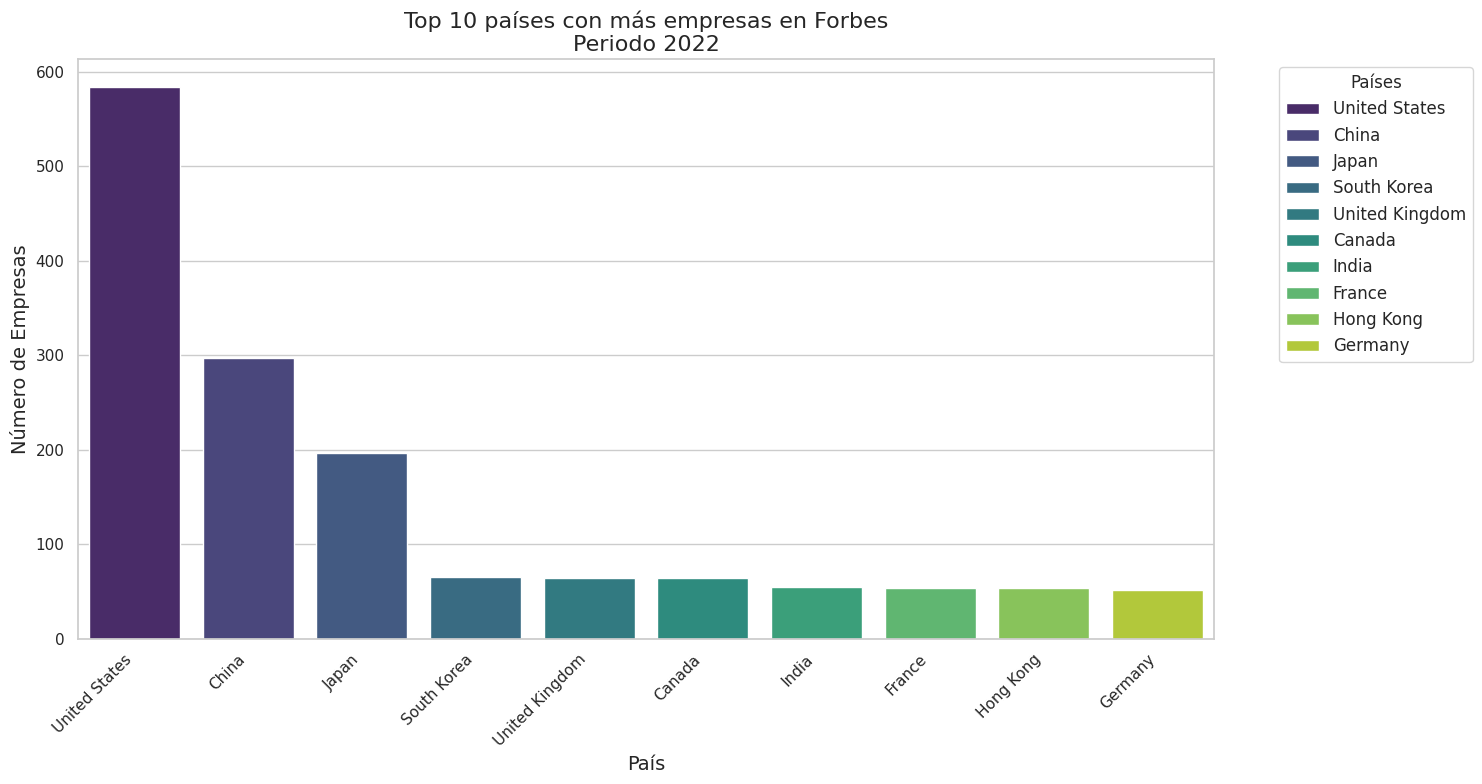

In [ ]:


# Top 10 países con más empresas
top_10_paises = df_merged['Pais'].value_counts().nlargest(10).reset_index()

# Renombrando las columnas para mayor claridad
top_10_paises.columns = ['País', 'Número de Empresas']

# Estableciendo el tamaño del lienzo
plt.figure(figsize=(15, 8))

# Creando el gráfico de barras con Seaborn y rota los nombres de los países
ax = sns.barplot(x='País', y='Número de Empresas', data=top_10_paises, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rota los nombres de los países

# Añadiendo un título y subtítulo
plt.title('Top 10 países con más empresas en Forbes\nPeriodo 2022', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.ylabel('Número de Empresas', fontsize=14)

# Añadiendo la leyenda con los colores asociados a los países
for bar, país in zip(ax.patches, top_10_paises['País']):
    bar.set_label(país)

plt.legend(title='Países', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustando automáticamente el diseño para evitar cortes
plt.tight_layout()

plt.show()

### ¿Cuál es el Top 4 de países con más empresas en el área de tecnología y de telecomunicaciones?

#### Tablas con respuestas:

In [ ]:
df_merged.Industria.unique()

array(['Diversified Financials', 'Banking', 'Oil & Gas Operations',
       'Retailing', 'Technology Hardware & Equipment',
       'Consumer Durables', 'IT Software & Services', 'Insurance',
       'Telecommunications Services', 'Media', 'Drugs & Biotechnology',
       'Food, Drink & Tobacco', 'Semiconductors', 'Materials',
       'Conglomerates', 'Trading Companies', 'Transportation',
       'Construction', 'Aerospace & Defense', 'Utilities',
       'Health Care Equipment & Services', 'Chemicals', 'Capital Goods',
       'Business Services & Supplies', 'Hotels, Restaurants & Leisure',
       'Food Markets'], dtype=object)

In [ ]:
df_tech_telco = df_merged[df_merged['Industria'].isin(['Technology Hardware & Equipment'])]

top_4_paises = df_tech_telco['Pais'].value_counts().nlargest(4).reset_index()

top_4_paises

index  Pais
0  United States    16
1         Taiwan    10
2          China    10
3          Japan     8

In [ ]:
df_tech_telco = df_merged[df_merged['Industria'].isin(['Telecommunications Services'])]

top_4_paises = df_tech_telco['Pais'].value_counts().nlargest(4).reset_index()

top_4_paises

index  Pais
0  United States     5
1          China     4
2          Japan     3
3    South Korea     3

#### Grafico de barras agrupadas:

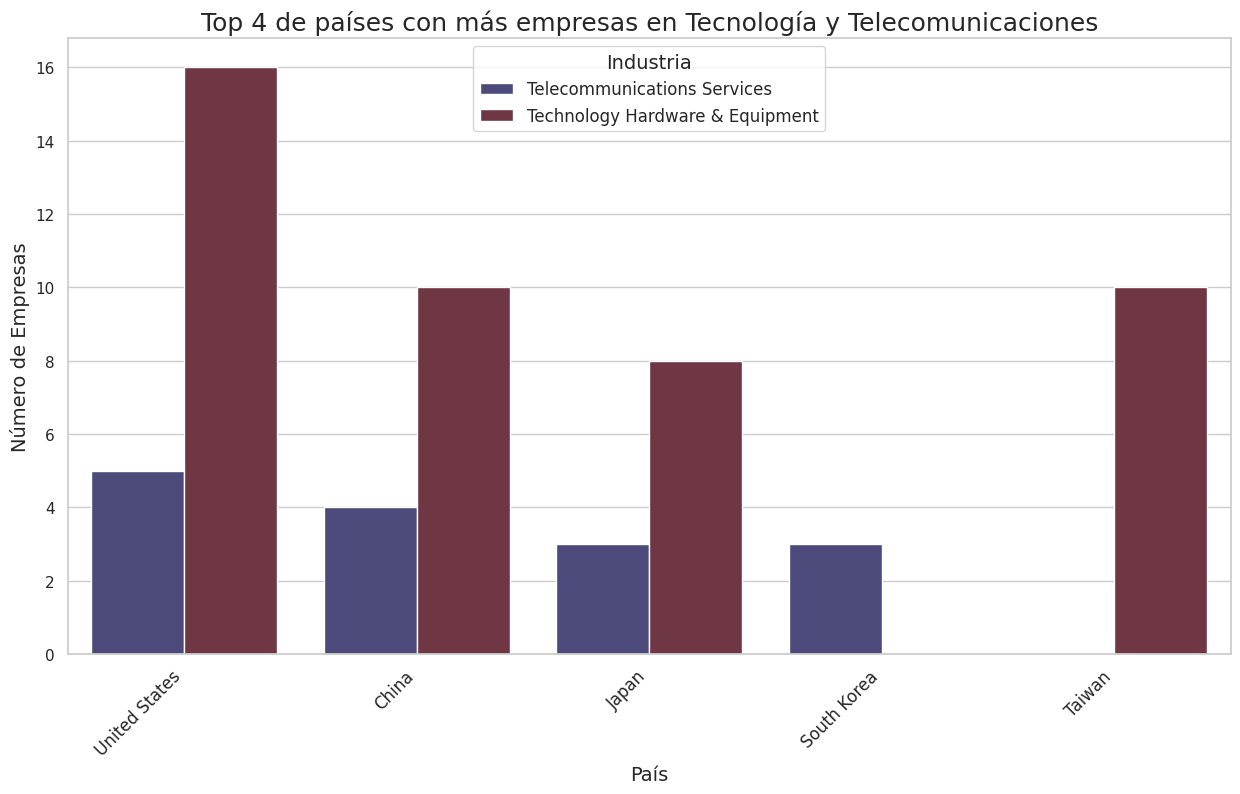

In [ ]:

# Filtrando el DataFrame
industrias_interes = ["Telecommunications Services", "Technology Hardware & Equipment"]
df_filtrado = df_merged[df_merged["Industria"].isin(industrias_interes)]

# Contando el número de empresas por país e industria
df_count = df_filtrado.groupby(["Pais", "Industria"]).size().reset_index(name="NumeroEmpresas")

# Obteniendo el Top 4 de países por industria
top4_paises_telecom = df_count[df_count["Industria"] == "Telecommunications Services"].nlargest(4, "NumeroEmpresas")
top4_paises_tech = df_count[df_count["Industria"] == "Technology Hardware & Equipment"].nlargest(4, "NumeroEmpresas")

# Creando la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 8))

# Creando el gráfico de barras agrupadas
sns.barplot(x="Pais", y="NumeroEmpresas", hue="Industria", data=pd.concat([top4_paises_telecom, top4_paises_tech]), palette="icefire")

# Personalizando la gráfica
ax.set_title("Top 4 de países con más empresas en Tecnología y Telecomunicaciones", fontsize=18)
ax.set_xlabel("País", fontsize=14)
ax.set_ylabel("Número de Empresas", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.legend(title="Industria", title_fontsize="14", fontsize="12")

plt.show()


#### Grafico de barras apiladas:

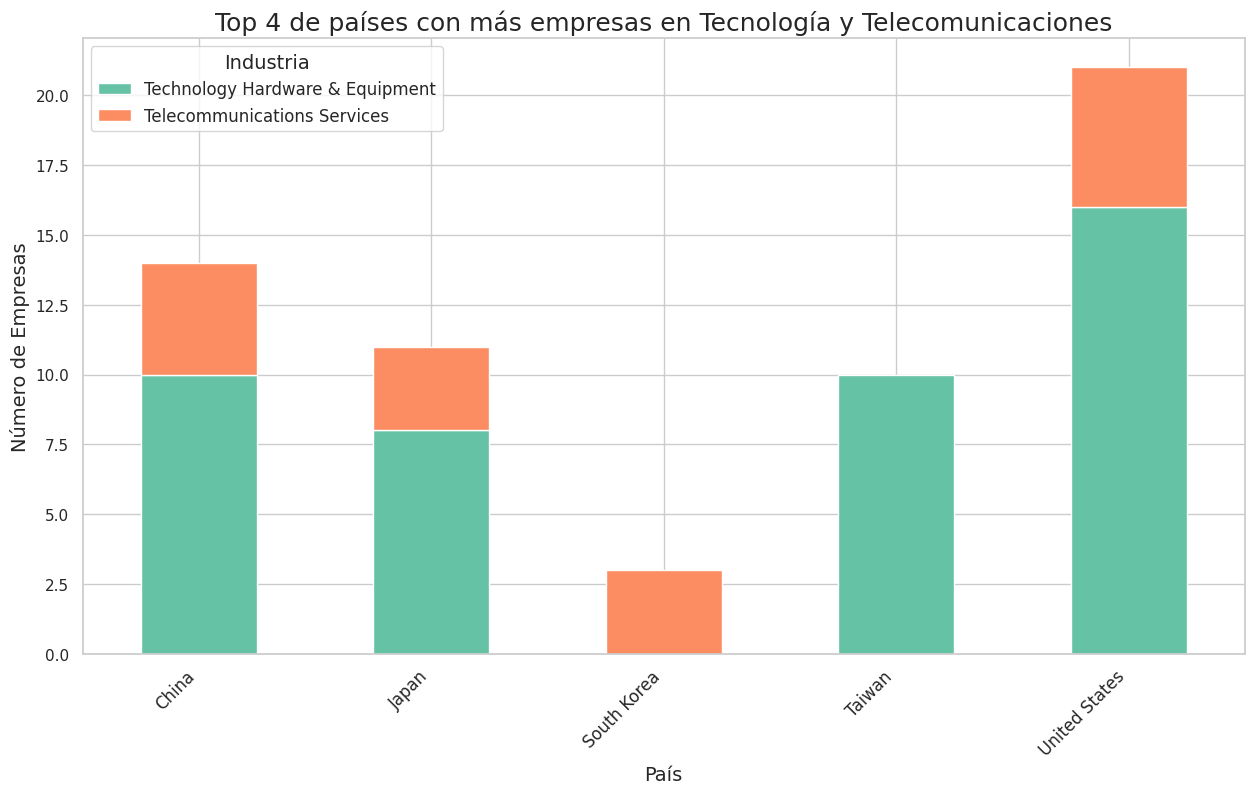

In [ ]:

# Combinando los resultados en un solo DataFrame
df_top4 = pd.concat([top4_paises_telecom, top4_paises_tech])

# Pivoteando el DataFrame para obtener un formato adecuado para un gráfico de barras apiladas
df_pivot = df_top4.pivot(index="Pais", columns="Industria", values="NumeroEmpresas").fillna(0)

# Creando la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 8))

# Creando el gráfico de barras apiladas con una paleta de colores diferente ("Set2")
sns.set_palette("Set2")
df_pivot.plot(kind="bar", stacked=True, ax=ax)

# Personalizando la gráfica
ax.set_title("Top 4 de países con más empresas en Tecnología y Telecomunicaciones", fontsize=18)
ax.set_xlabel("País", fontsize=14)
ax.set_ylabel("Número de Empresas", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.legend(title="Industria", title_fontsize="14", fontsize="12")

plt.show()




### ¿Cuál fue el margen de pérdida de las 5 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

In [ ]:
df_merged.Industria.unique()

array(['Diversified Financials', 'Banking', 'Oil & Gas Operations',
       'Retailing', 'Technology Hardware & Equipment',
       'Consumer Durables', 'IT Software & Services', 'Insurance',
       'Telecommunications Services', 'Media', 'Drugs & Biotechnology',
       'Food, Drink & Tobacco', 'Semiconductors', 'Materials',
       'Conglomerates', 'Trading Companies', 'Transportation',
       'Construction', 'Aerospace & Defense', 'Utilities',
       'Health Care Equipment & Services', 'Chemicals', 'Capital Goods',
       'Business Services & Supplies', 'Hotels, Restaurants & Leisure',
       'Food Markets'], dtype=object)

In [ ]:
df_merged[df_merged["Margen de Rentabilidad"] < 0 ]["Industria"].isin(["Hotels, Restaurants & Leisure"])

435     False
473     False
487     False
548     False
605     False
        ...  
1978    False
1997    False
2016    False
2018    False
2020    False
Name: Industria, Length: 123, dtype: bool

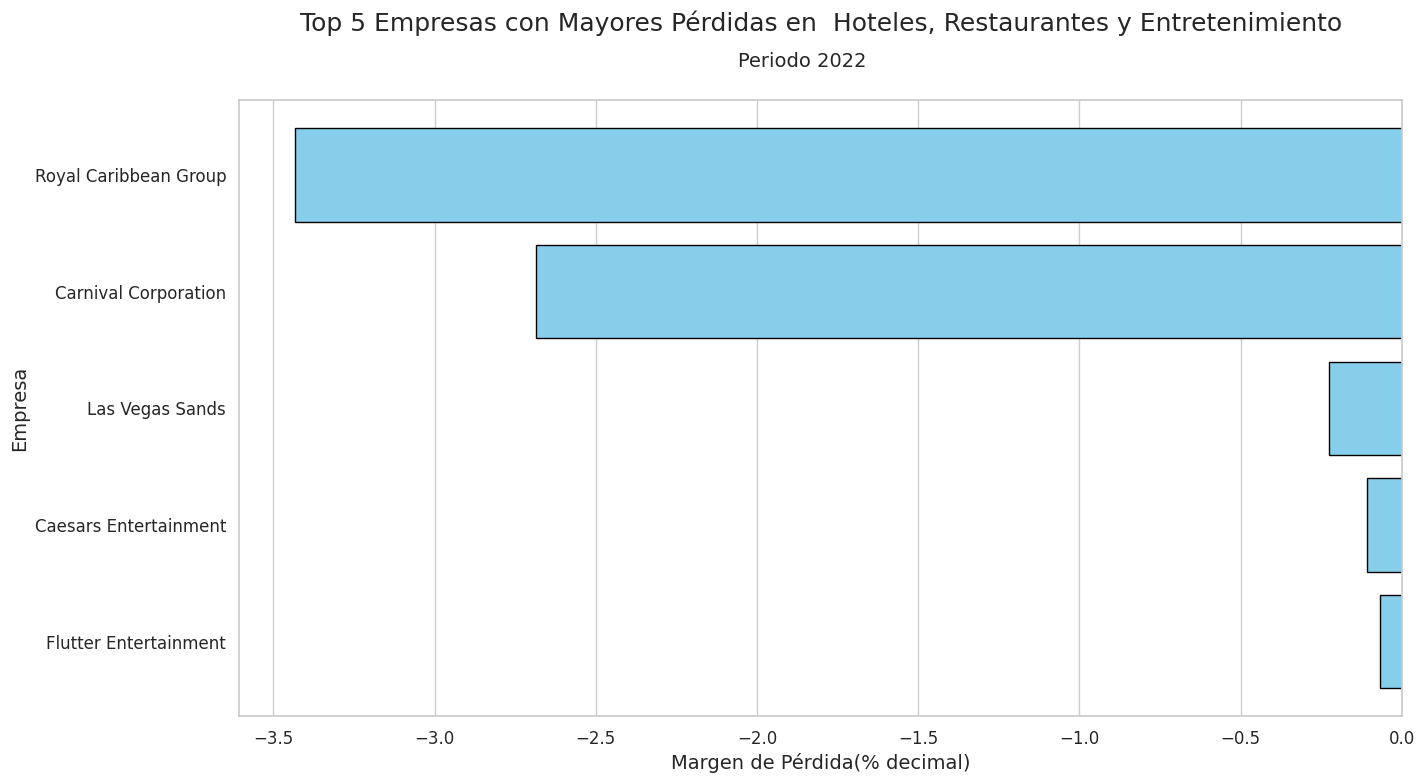

In [ ]:

# Filtrando el DataFrame para obtener solo las empresas de la industria deseada y ordenando por margen de pérdida
df_hotels = df_merged[df_merged['Industria'] == 'Hotels, Restaurants & Leisure']
df_hotels_sorted = df_hotels.sort_values(by='Margen de Rentabilidad', ascending=True)

# Seleccionando las 5 empresas con mayores pérdidas
top_5_empresas = df_hotels_sorted.nsmallest(5, 'Margen de Rentabilidad')

# Configurando el tamaño del lienzo y el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Creando el gráfico de barras horizontales
sns.barplot(x='Margen de Rentabilidad', y='Empresa', data=top_5_empresas, palette='viridis', errorbar=None, capsize=0.2)

# Configurando el título y subtítulo
plt.title('Top 5 Empresas con Mayores Pérdidas en  Hoteles, Restaurantes y Entretenimiento', y=1.1, fontsize=18)
plt.suptitle('Periodo 2022', y=0.94, fontsize=14)

# Configurando los nombres de los ejes
plt.xlabel('Margen de Pérdida(% decimal)', fontsize=14)
plt.ylabel('Empresa', fontsize=14)

# Cambiando el grosor de las barras
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Cambiando el color de las barras
plt.barh(top_5_empresas['Empresa'], top_5_empresas['Margen de Rentabilidad'], color='skyblue', edgecolor='black', height=0.8, capsize=0.2)

plt.show()



In [ ]:
top_5_empresas

Rank_nr                Empresa                      Industria  \
1400    1376  Royal Caribbean Group  Hotels, Restaurants & Leisure   
1238    1220   Carnival Corporation  Hotels, Restaurants & Leisure   
1556    1529        Las Vegas Sands  Hotels, Restaurants & Leisure   
1189    1172  Caesars Entertainment  Hotels, Restaurants & Leisure   
1337    1316  Flutter Entertainment  Hotels, Restaurants & Leisure   

               Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
1400  United States      1532    -5260.5    32258             20821   
1238  United States      3506    -9419.0    53281             21455   
1556  United States      4234     -961.0    20059             27809   
1189  United States      9477    -1019.0    38031             14261   
1337        Ireland      8302     -571.9    22722             18655   

      Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  \
1400               -3.433747                          -0.163076  2022     USA   
1238               -2.686537                          -0.176780  2022     USA   
1556               -0.226972                          -0.047909  2022     USA   
1189               -0.107523                          -0.026794  2022     USA   
1337               -0.068887                          -0.025169  2022     IRL   

     Nombre_continente  
1400     North America  
1238     North America  
1556     North America  
1189     North America  
1337            Europe

###Considerando a la Industria Petrolera en Asia, ¿Cuál o cuáles empresas superaron en más del 20% su margen de rentabilidad?

In [ ]:
df_merged.head()

Rank_nr                                   Empresa               Industria  \
0       1                        Berkshire Hathaway  Diversified Financials   
1       2                                      ICBC                 Banking   
2       3  Saudi Arabian Oil Company (Saudi Aramco)    Oil & Gas Operations   
3       4                            JPMorgan Chase  Diversified Financials   
4       5                   China Construction Bank                 Banking   

            Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
0  United States    276094    89795.0   958784            741476   
1          China    208127    54028.3  5518508            214425   
2   Saudi Arabia    400376   105363.0   576041           2292077   
3  United States    124542    42115.0  3954687            374446   
4          China    202069    46887.3  4746951            181325   

   Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  \
0                0.325233                           0.093655  2022     USA   
1                0.259593                           0.009790  2022     CHN   
2                0.263160                           0.182909  2022     SAU   
3                0.338159                           0.010649  2022     USA   
4                0.232036                           0.009877  2022     CHN   

  Nombre_continente  
0     North America  
1              Asia  
2              Asia  
3     North America  
4              Asia

In [ ]:
df_merged.Industria.unique()

array(['Diversified Financials', 'Banking', 'Oil & Gas Operations',
       'Retailing', 'Technology Hardware & Equipment',
       'Consumer Durables', 'IT Software & Services', 'Insurance',
       'Telecommunications Services', 'Media', 'Drugs & Biotechnology',
       'Food, Drink & Tobacco', 'Semiconductors', 'Materials',
       'Conglomerates', 'Trading Companies', 'Transportation',
       'Construction', 'Aerospace & Defense', 'Utilities',
       'Health Care Equipment & Services', 'Chemicals', 'Capital Goods',
       'Business Services & Supplies', 'Hotels, Restaurants & Leisure',
       'Food Markets'], dtype=object)

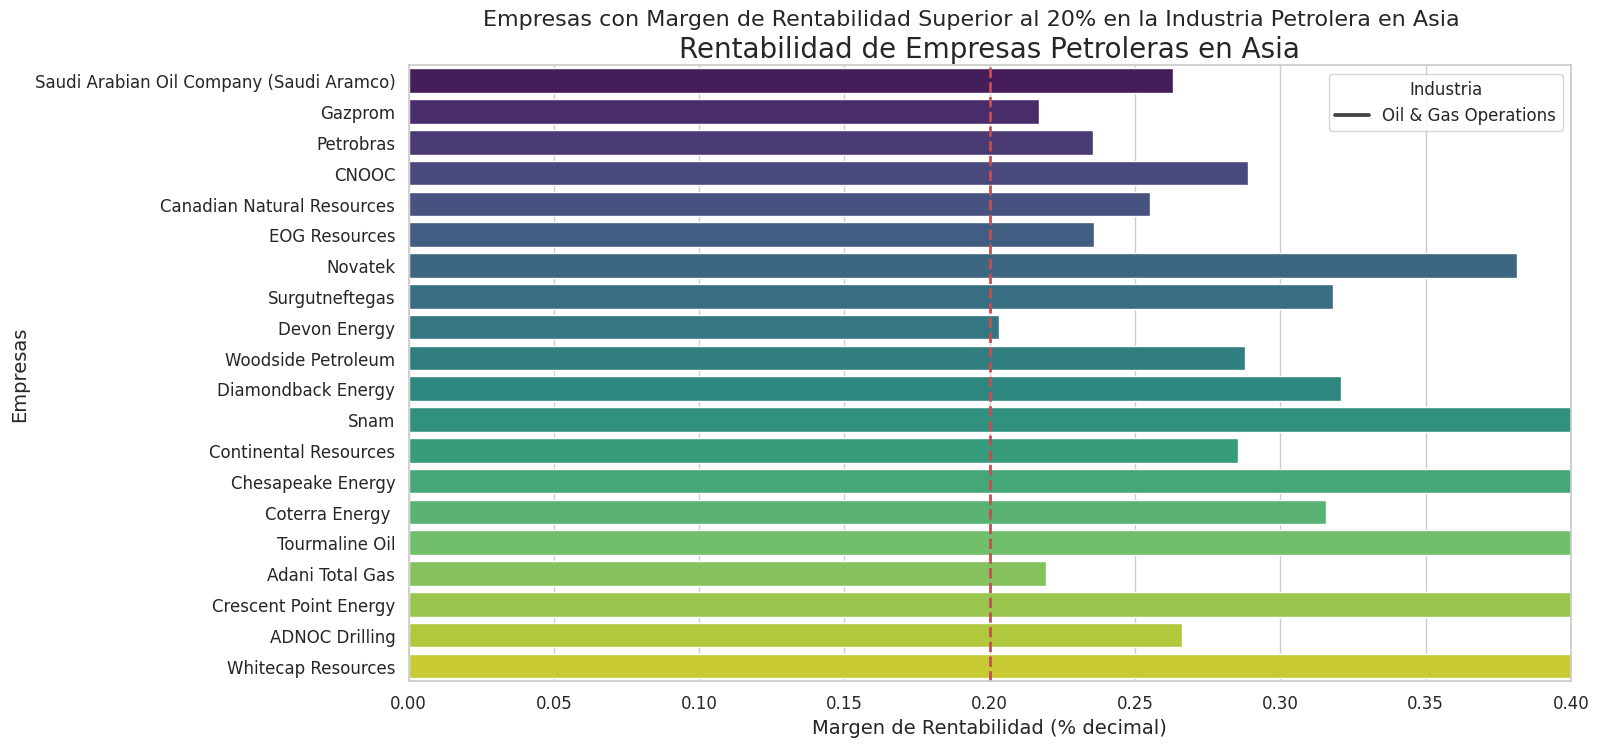

In [ ]:

# Filtrando el DataFrame por la industria "Oil & Gas Operations" y margen de rentabilidad superior al 20%
df_filtered = df_merged[(df_merged['Industria'] == 'Oil & Gas Operations') & (df_merged['Margen de Rentabilidad'] > 0.2)]

# Configurando el lienzo y el estilo de Seaborn
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

# Creando el gráfico de barras horizontales
barplot = sns.barplot(x='Margen de Rentabilidad', y='Empresa', data=df_filtered, palette='viridis')

# Configuraciones de la visualización
plt.title('Rentabilidad de Empresas Petroleras en Asia', fontsize=20)
plt.xlabel('Margen de Rentabilidad (% decimal)', fontsize=14)
plt.ylabel('Empresas', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 0.4)  # Ajusta el rango del eje x según tus datos

# Añadiendo la leyenda
plt.legend(title='Industria', labels=['Oil & Gas Operations'], fontsize=12)

# Añadiendo línea de referencia del 20% de margen de rentabilidad
plt.axvline(x=0.2, color='r', linestyle='--', linewidth=2, label='20% Margen de Rentabilidad')

# Añadiendo subtítulo
plt.suptitle('Empresas con Margen de Rentabilidad Superior al 20% en la Industria Petrolera en Asia', fontsize=16, y=0.95)

plt.show()


### ¿Cuáles fueron las empresas norteamericanas con el mayor porcentaje de rentabilidad por industria?

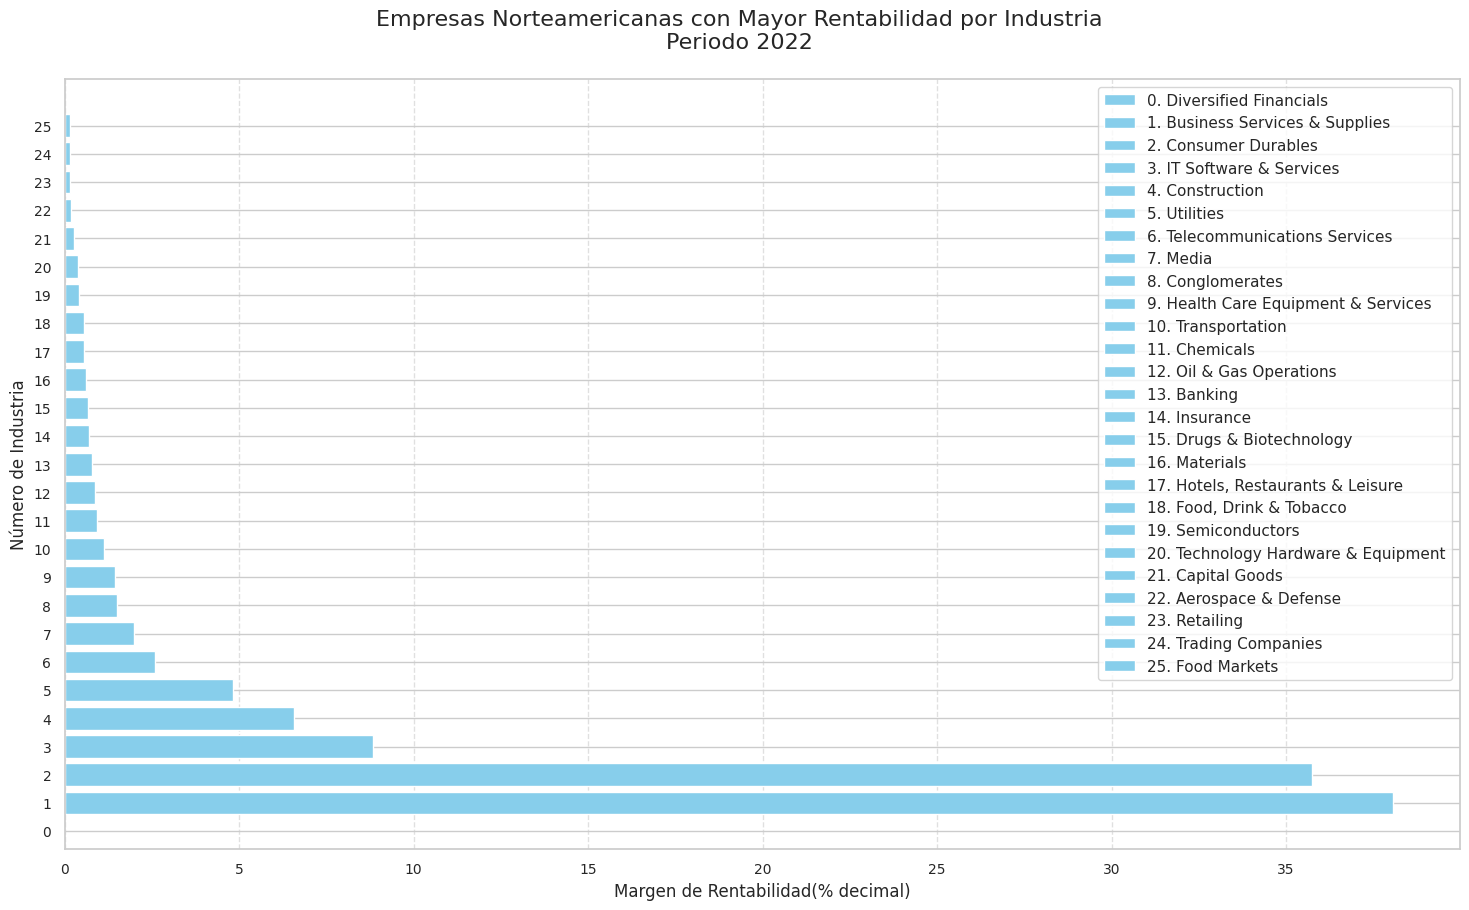

In [ ]:

# Buscando las empresas con el mayor porcentaje de rentabilidad por industria
empresas_top_por_industria = df_merged.groupby('Industria').apply(lambda x: x.loc[x['Margen de Rentabilidad'].idxmax()])

# Ordenando el dataframe por margen de rentabilidad
empresas_top_por_industria = empresas_top_por_industria.sort_values(by='Margen de Rentabilidad', ascending=False)

# Configuración de la gráfica
fig, ax = plt.subplots(figsize=(18, 10))  # Se ha aumentado el tamaño del lienzo
bar_colors = 'skyblue'
bar_width = 0.8

# Creando la gráfica de barras horizontales
bars = ax.barh(np.arange(len(empresas_top_por_industria)), empresas_top_por_industria['Margen de Rentabilidad'],
               color=bar_colors, height=bar_width)

# Etiquetando el eje y con números del 0 al número necesario
ax.set_yticks(np.arange(len(empresas_top_por_industria)))
ax.set_yticklabels(np.arange(len(empresas_top_por_industria)))

# Añadiendo la leyenda con el nombre de la industria y su número correspondiente
legend_labels = [f"{i}. {industria}" for i, industria in enumerate(empresas_top_por_industria['Industria'])]
ax.legend(bars, legend_labels, loc='upper right')

# Añadiendo etiquetas y título
ax.set_xlabel('Margen de Rentabilidad(% decimal)')
ax.set_ylabel('Número de Industria')

# Ajustando el formato del gráfico
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Añadiendo el título principal y subtítulo
fig.suptitle('Empresas Norteamericanas con Mayor Rentabilidad por Industria\nPeriodo 2022', fontsize=16, y=0.95)
ax.set_title('')

plt.show()


In [ ]:
df_merged.groupby('Industria')[["Margen de Rentabilidad","Empresa"]].max()

Margen de Rentabilidad  \
Industria                                                  
Aerospace & Defense                             0.196400   
Banking                                         0.777660   
Business Services & Supplies                   38.062162   
Capital Goods                                   0.260866   
Chemicals                                       0.928410   
Conglomerates                                   1.493329   
Construction                                    6.565734   
Consumer Durables                              35.741722   
Diversified Financials                               inf   
Drugs & Biotechnology                           0.663080   
Food Markets                                    0.154649   
Food, Drink & Tobacco                           0.557137   
Health Care Equipment & Services                1.452583   
Hotels, Restaurants & Leisure                   0.566587   
IT Software & Services                          8.847368   
Insurance                                       0.700915   
Materials                                       0.628893   
Media                                           1.992624   
Oil & Gas Operations                            0.864835   
Retailing                                       0.162417   
Semiconductors                                  0.421718   
Technology Hardware & Equipment                 0.400917   
Telecommunications Services                     2.579592   
Trading Companies                               0.156240   
Transportation                                  1.131540   
Utilities                                       4.816463   

                                                           Empresa  
Industria                                                           
Aerospace & Defense                                TransDigm Group  
Banking                                              Zions Bancorp  
Business Services & Supplies                                  eBay  
Capital Goods                              Zoomlion Heavy Industry  
Chemicals                                        Yunnan Yuntianhua  
Conglomerates                                     Wharf (Holdings)  
Construction                                  Zhongliang Holdings   
Consumer Durables                                            tesla  
Diversified Financials                    Yuanta Financial Holding  
Drugs & Biotechnology                                       Zoetis  
Food Markets                                       X5 Retail Group  
Food, Drink & Tobacco                              Wuliangye Yibin  
Health Care Equipment & Services                     Zimmer Biomet  
Hotels, Restaurants & Leisure                          Yum! Brands  
IT Software & Services                   Zoom Video Communications  
Insurance                                 iA Financial Corporation  
Materials                                       Zijin Mining Group  
Media                                               Wolters Kluwer  
Oil & Gas Operations                                          YPF   
Retailing                                Zhongsheng Group Holdings  
Semiconductors                                  Will Semiconductor  
Technology Hardware & Equipment                 Zebra Technologies  
Telecommunications Services                               Vodafone  
Trading Companies                 Xiamen International Trade Group  
Transportation                        Zhejiang Expressway Co. Ltd.  
Utilities                                              Xcel Energy

### Excluyendo a la industria Bancaria, ¿Cuáles fueron las empresas europeas con mayores pérdidas registradas por industria a nivel global?

In [ ]:
df_merged[df_merged["Ganancias"] < 0]

Rank_nr                    Empresa                    Industria  \
435      431                     Boeing          Aerospace & Defense   
473      468                     JD.com                    Retailing   
487      481                   Vodafone  Telecommunications Services   
548      541                 Prudential                    Insurance   
605      598        Credit Suisse Group                      Banking   
...      ...                        ...                          ...   
1978    1945    Hainan Airlines Holding               Transportation   
1997    1964  Zall Smart Commerce Group                 Construction   
2016    1983             Unity Software       IT Software & Services   
2018    1984                    Li Auto            Consumer Durables   
2020    1986                     Twilio       IT Software & Services   

                Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
435           Canada     62286    -4202.0   138552            104451   
473            China    147626     -560.4    77904             68560   
487   United Kingdom     53627     -291.0   178591             46356   
548   United Kingdom     26525    -1984.9   189349             36705   
605      Switzerland     30065    -1804.7   829537             18683   
...              ...       ...        ...      ...               ...   
1978           China      5634    -7961.8    33031              8756   
1997           China     16213     -179.2     9301               698   
2016   United States      1111     -532.6     4841             22405   
2018           China      4198      -48.9     9704             22394   
2020   United States      2842     -949.9    12999             22287   

      Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  \
435                -0.067463                          -0.030328  2022     CAN   
473                -0.003796                          -0.007193  2022     CHN   
487                -0.005426                          -0.001629  2022     GBR   
548                -0.074831                          -0.010483  2022     GBR   
605                -0.060027                          -0.002176  2022     CHE   
...                      ...                                ...    ...    ...   
1978               -1.413170                          -0.241040  2022     CHN   
1997               -0.011053                          -0.019267  2022     CHN   
2016               -0.479388                          -0.110019  2022     USA   
2018               -0.011648                          -0.005039  2022     CHN   
2020               -0.334236                          -0.073075  2022     USA   

     Nombre_continente  
435      North America  
473               Asia  
487             Europe  
548             Europe  
605             Europe  
...                ...  
1978              Asia  
1997              Asia  
2016     North America  
2018              Asia  
2020     North America  

[123 rows x 13 columns]

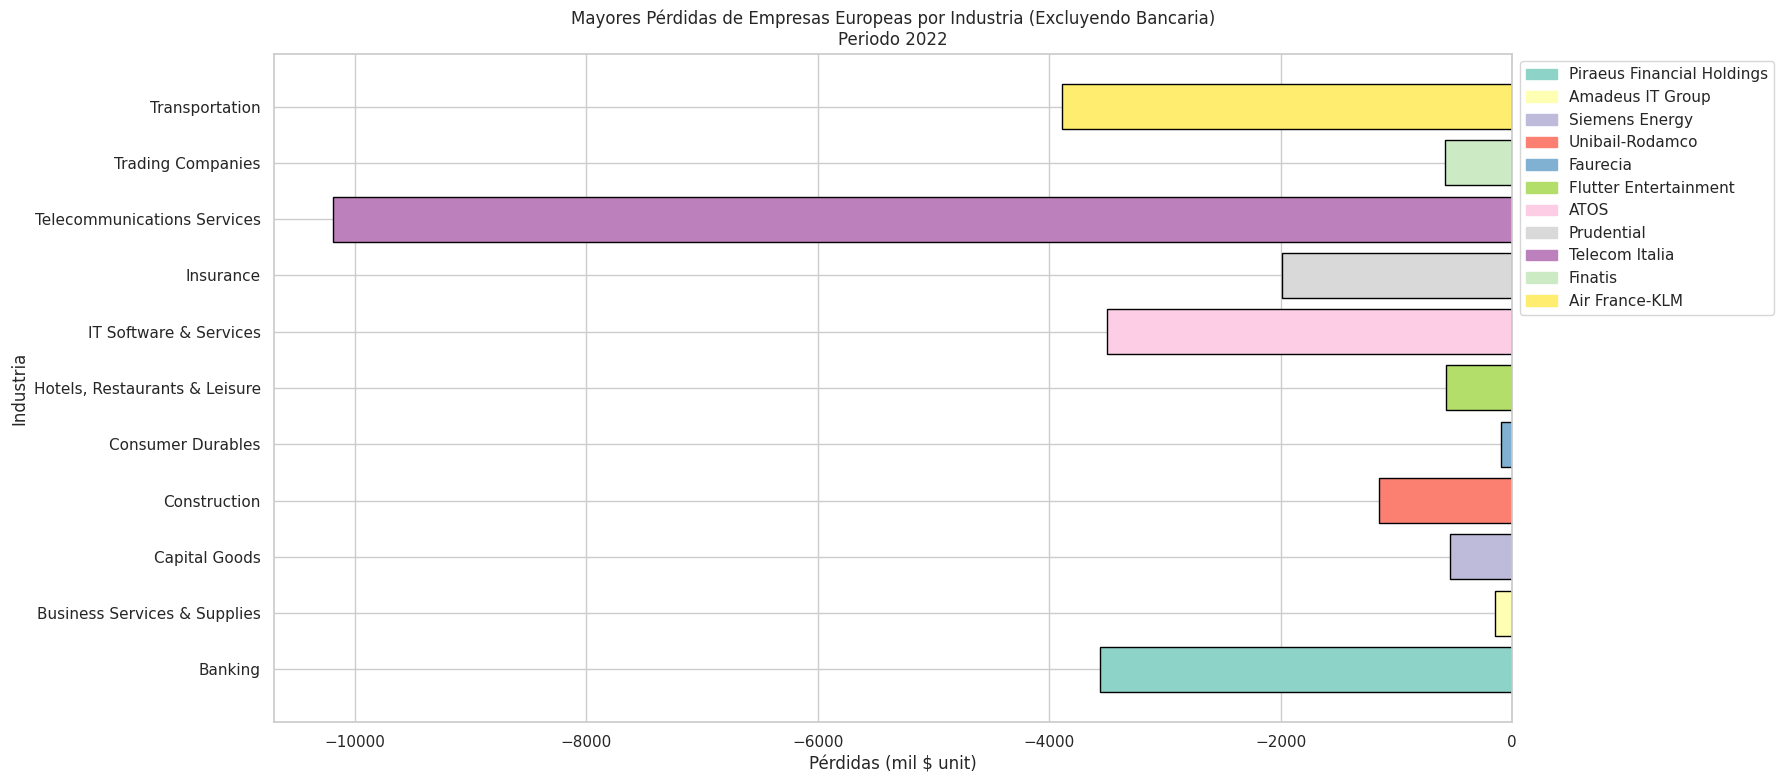

In [ ]:

# Filtrando el dataframe por empresas europeas y pérdidas
df_europe_losses = df_merged[(df_merged['Nombre_continente'] == 'Europe') & (df_merged['Ganancias'] < 0)]

# Excluyendo la industria bancaria
df_europe_losses = df_europe_losses[df_europe_losses['Industria'] != 'Bancaria']

# Encontrando las mayores pérdidas por industria
top_losses_by_industry = df_europe_losses.groupby('Industria')['Ganancias'].idxmin()
top_losses_df = df_europe_losses.loc[top_losses_by_industry, ['Industria', 'Empresa', 'Ganancias']]

plt.figure(figsize=(18, 8))

bar_width = 0.8

# Creando el gráfico de barras sin malla en ambos ejes
colors = plt.cm.Set3(np.linspace(0, 1, len(top_losses_df)))
bars = plt.barh(top_losses_df['Industria'], top_losses_df['Ganancias'], color=colors, height=bar_width, edgecolor='black')

# Añadiendo leyenda para la simbología
legend_elements = [Patch(color=color, label=label) for color, label in zip(colors, top_losses_df['Empresa'])]
legend = plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Añadiendo nombre a cada eje
plt.xlabel('Pérdidas (mil $ unit)')
plt.ylabel('Industria')

# Añadiendo Titulo y subtitulo
plt.title('Mayores Pérdidas de Empresas Europeas por Industria (Excluyendo Bancaria)\nPeriodo 2022')

plt.tight_layout()

plt.show()


###¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 3 millones de dólares?

In [ ]:
df_merged[df_merged["Activos"] < 3000000]

Rank_nr                                    Empresa  \
0          1                         Berkshire Hathaway   
2          3   Saudi Arabian Oil Company (Saudi Aramco)   
5          6                                     Amazon   
6          7                                      Apple   
9         10                               Toyota Motor   
...      ...                                        ...   
2029    1995  Shenzhen Feima International Supply Chain   
2030    1997                                       NMDC   
2031    1997                 Sichuan Changhong Electric   
2032    1999                         Satellite Chemical   
2033    2000                            Sun Communities   

                            Industria           Pais  Ingresos  Ganancias  \
0              Diversified Financials  United States    276094    89795.0   
2                Oil & Gas Operations   Saudi Arabia    400376   105363.0   
5                           Retailing  United States    469822    33364.0   
6     Technology Hardware & Equipment  United States    378697   100555.0   
9                   Consumer Durables          Japan    281746    28154.4   
...                               ...            ...       ...        ...   
2029     Business Services & Supplies          China        37     1408.3   
2030                        Materials          India      3520     1406.4   
2031                Consumer Durables          China     15716       53.1   
2032                        Chemicals          China      4413      931.3   
2033           Diversified Financials  United States      2273      375.7   

      Activos  Valor de Mercado  Margen de Rentabilidad  \
0      958784            741476                0.325233   
2      576041           2292077                0.263160   
5      420549           1468398                0.071014   
6      381191           2640316                0.265529   
9      552456            237726                0.099928   
...       ...               ...                     ...   
2029      166              1136               38.062162   
2030     5715              6401                0.399545   
2031    12105              1957                0.003379   
2032     7640              9521                0.211036   
2033    13494             21714                0.165288   

      Rentabilidad de los Activos (ROA)    Año Codigo Nombre_continente  
0                              0.093655  2022     USA     North America  
2                              0.182909  2022     SAU              Asia  
5                              0.079334  2022     USA     North America  
6                              0.263792  2022     USA     North America  
9                              0.050962  2022     JPN              Asia  
...                                 ...    ...    ...               ...  
2029                           8.483735  2022     CHN              Asia  
2030                           0.246089  2022     IND              Asia  
2031                           0.004387  2022     CHN              Asia  
2032                           0.121898  2022     CHN              Asia  
2033                           0.027842  2022     USA     North America  

[2024 rows x 13 columns]

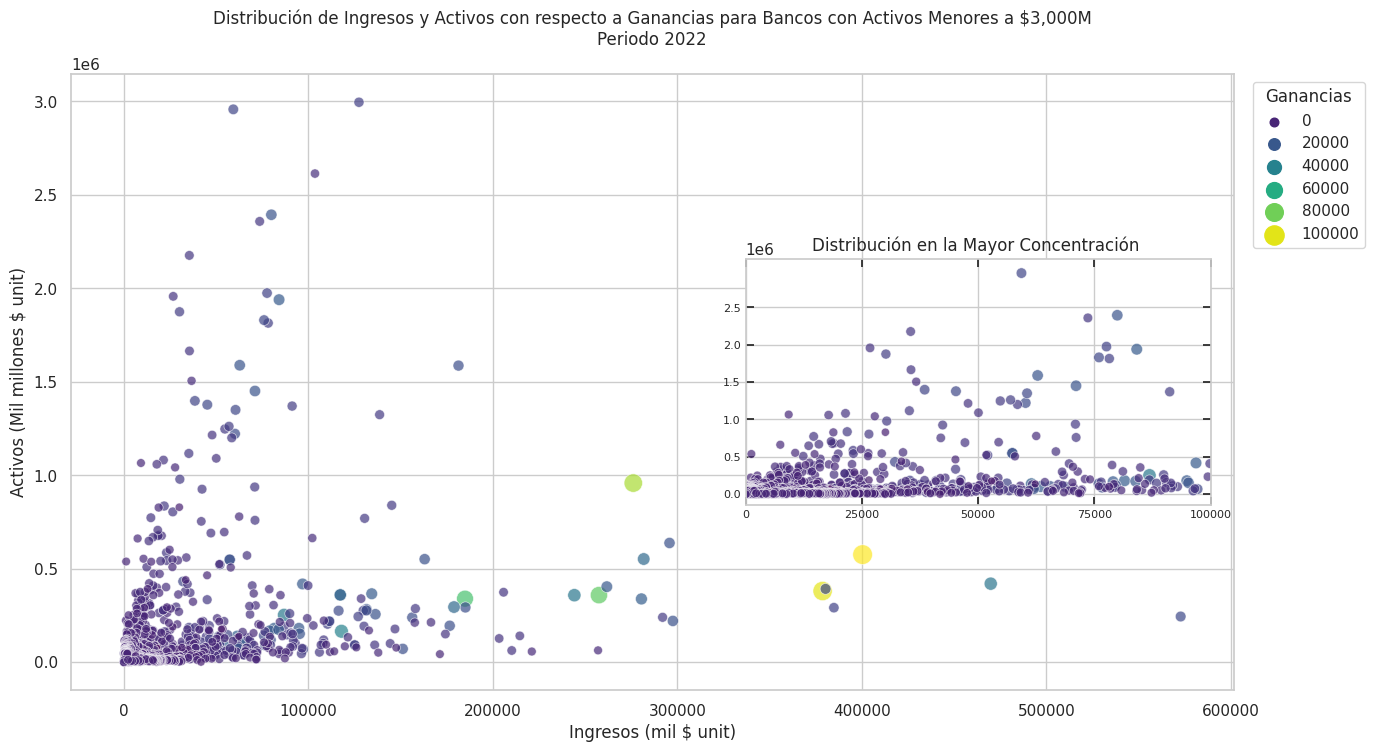

In [ ]:

# Filtrando los datos para bancos con activos menores a 3,000 millones de dolares
df_filtered = df_merged[df_merged['Activos'] < 3000000]

# Configuración del lienzo principal
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Distribución de Ingresos y Activos con respecto a Ganancias para Bancos con Activos Menores a $3,000M\nPeriodo 2022\n')
ax.set_xlabel('Ingresos (mil $ unit)')
ax.set_ylabel('Activos (Mil millones $ unit)')

# Creando un gráfico de burbujas
sns.scatterplot(x='Ingresos', y='Activos', size='Ganancias', hue='Ganancias', data=df_filtered, palette='viridis', sizes=(20, 200), alpha=0.7, ax=ax)

# Añadiendo leyenda en el lienzo principal
legend = ax.legend(title='Ganancias', bbox_to_anchor=(1, 1))

# Configuración del lienzo secundario (zoom en ingresos hasta $100,000)
axins = inset_axes(ax, width="40%", height="40%", loc='right', borderpad=1.5)
axins.set_xlim(0, 100000)
axins.set_ylim(ax.get_ylim())

# Creando un segundo gráfico de burbujas en el lienzo secundario
sns.scatterplot(x='Ingresos', y='Activos', size='Ganancias', hue='Ganancias', data=df_filtered, palette='viridis', sizes=(20, 200), alpha=0.7, ax=axins)

# Agregando título al segundo lienzo
axins.set_title('Distribución en la Mayor Concentración ', fontsize=12)

# Quitando etiquetas de ejes en el lienzo secundario
axins.set_xlabel('')
axins.set_ylabel('')

# Eliminando la leyenda del segundo lienzo
axins.get_legend().remove()

# Agregando ticks en el eje x e y en el lienzo secundario
axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.tick_params(axis='both', which='both', direction='in', labelsize=8)

# Estableciendo ticks específicos para el lienzo secundario
axins.set_xticks([0, 25000, 50000, 75000, 100000])
axins.set_yticks([0, 500000, 1000000, 1500000, 2000000, 2500000])

# Colocando la leyenda del primer lienzo un poco más arriba
legend.set_bbox_to_anchor((1.12, 1.0))

plt.show()


In [ ]:
df_filtered = df_merged[df_merged['Activos'] > 3000000]
df_filtered

Rank_nr                     Empresa                     Industria  \
1         2                        ICBC                       Banking   
3         4              JPMorgan Chase        Diversified Financials   
4         5     China Construction Bank                       Banking   
7         8  Agricultural Bank of China                       Banking   
8         9             Bank of America                       Banking   
12       13               Bank of China                       Banking   
58       58    Mitsubishi UFJ Financial                       Banking   
341     338                  Fannie Mae  Business Services & Supplies   
366     363                 Freddie Mac  Business Services & Supplies   

              Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
1            China    208127    54028.3  5518508            214425   
3    United States    124542    42115.0  3954687            374446   
4            China    202069    46887.3  4746951            181325   
7            China    181420    37378.5  4561048            133385   
8    United States     96826    30995.0  3238223            303102   
12           China    152425    33574.4  4192836            117825   
58           Japan     48280    11289.2  3176374             75750   
341  United States    100328    22176.0  4229901               880   
366  United States     62238    12109.0  3025586               488   

     Margen de Rentabilidad  Rentabilidad de los Activos (ROA)    Año Codigo  \
1                  0.259593                           0.009790  2022     CHN   
3                  0.338159                           0.010649  2022     USA   
4                  0.232036                           0.009877  2022     CHN   
7                  0.206033                           0.008195  2022     CHN   
8                  0.320110                           0.009572  2022     USA   
12                 0.220268                           0.008008  2022     CHN   
58                 0.233828                           0.003554  2022     JPN   
341                0.221035                           0.005243  2022     USA   
366                0.194560                           0.004002  2022     USA   

    Nombre_continente  
1                Asia  
3       North America  
4                Asia  
7                Asia  
8       North America  
12               Asia  
58               Asia  
341     North America  
366     North America

### Considerando el histórico de valores de las acciones en el año 2022 de las 5 empresas de tu elección (Paso 2), Indica ¿Cuál fue la mejor semana para comprar y cuál para vender respectivamente? (Se compra cuando el precio es bajo, y se vende cuando el precio es alto)

In [ ]:
df_apple = pd.read_csv("/content/datos_empresa_AAPL.csv")
df_amazon = pd.read_csv("/content/datos_empresa_AMZN.csv")
df_meta1 = pd.read_csv("/content/datos_empresa_FB.csv")
df_meta2 = pd.read_csv("/content/datos_empresa_META.csv")
df_google = pd.read_csv("/content/datos_empresa_GOOGL.csv")
df_microsoft = pd.read_csv("/content/datos_empresa_MSFT.csv")

In [ ]:
df_apple.head()

symbol              t        o       c       h       l
0   AAPL  1640494800000  177.085  177.57  181.33  177.07
1   AAPL  1641099600000  177.830  172.17  182.94  171.03
2   AAPL  1641704400000  169.080  173.07  177.18  168.17
3   AAPL  1642309200000  171.510  162.41  172.54  162.30
4   AAPL  1642914000000  160.020  170.33  170.35  154.70

In [ ]:
df_meta1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  24 non-null     object 
 1   t       24 non-null     int64  
 2   o       24 non-null     float64
 3   c       24 non-null     float64
 4   h       24 non-null     float64
 5   l       24 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ KB


In [ ]:
df_meta2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  35 non-null     object 
 1   t       35 non-null     int64  
 2   o       35 non-null     float64
 3   c       35 non-null     float64
 4   h       35 non-null     float64
 5   l       35 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ KB


In [ ]:
# Tratando especialmente los datos de META por su cambio de nombre en 2022
df_meta1.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)
df_meta2.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)

df_meta1['fecha'] = pd.to_datetime(df_meta1['fecha'], unit='ms')
df_meta2['fecha'] = pd.to_datetime(df_meta2['fecha'], unit='ms')

# Identificando la fecha de cambio de nombre
fecha_cambio_nombre = '2022-10-28'

# Separando los dataframes en función de la fecha de cambio de nombre
df_facebook = df_meta1[df_meta1['fecha'] < fecha_cambio_nombre]
df_meta = df_meta2[df_meta2['fecha'] >= fecha_cambio_nombre]

# Combinando los dataframes
df_completo_meta = pd.concat([df_facebook, df_meta])

df_completo_meta = df_completo_meta.sort_values('fecha')


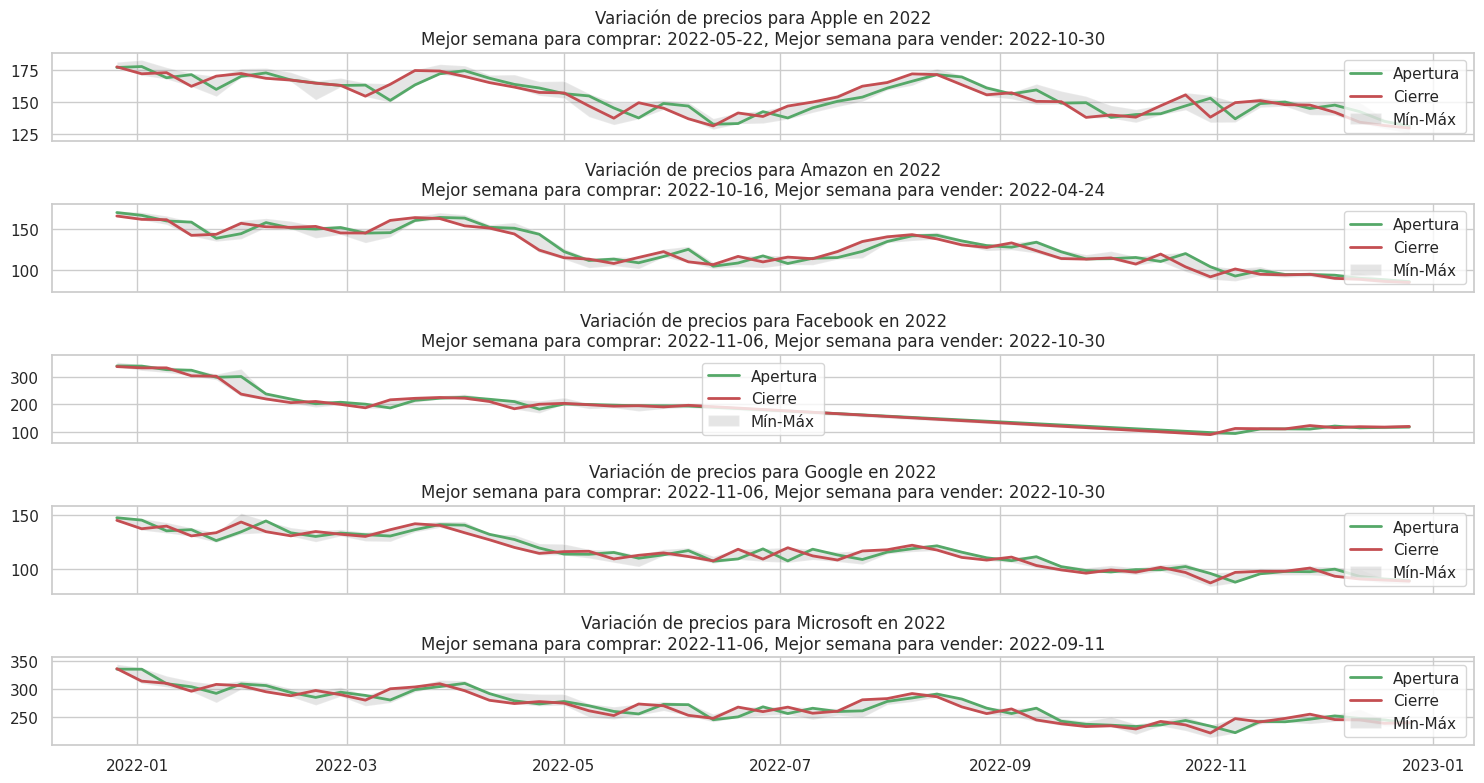

In [ ]:

# Cambiando los nombres de las columnas
df_apple.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)
df_amazon.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)
df_google.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)
df_microsoft.rename(columns={'symbol': 'símbolo', 't': 'fecha', 'o': 'apertura', 'c': 'cierre', 'h': 'máximo', 'l': 'mínimo'}, inplace=True)

# Convertiendo la columna de fecha a objetos de fecha
df_apple['fecha'] = pd.to_datetime(df_apple['fecha'], unit='ms')
df_amazon['fecha'] = pd.to_datetime(df_amazon['fecha'], unit='ms')
df_google['fecha'] = pd.to_datetime(df_google['fecha'], unit='ms')
df_microsoft['fecha'] = pd.to_datetime(df_microsoft['fecha'], unit='ms')

# Calculando los retornos semanales para cada empresa
df_apple['retorno_semanal'] = df_apple['cierre'].pct_change()
df_amazon['retorno_semanal'] = df_amazon['cierre'].pct_change()
df_completo_meta['retorno_semanal'] = df_completo_meta['cierre'].pct_change()
df_google['retorno_semanal'] = df_google['cierre'].pct_change()
df_microsoft['retorno_semanal'] = df_microsoft['cierre'].pct_change()

# Identificando la mejor semana para comprar y vender en cada empresa

def mejor_semana_comprar_vender_retornos(df):
    semana_compra = df.loc[df['retorno_semanal'].idxmax()]['fecha'].strftime('%Y-%m-%d')
    semana_venta = df.loc[df['retorno_semanal'].idxmin()]['fecha'].strftime('%Y-%m-%d')
    return semana_compra, semana_venta

# Llamando a la función para cada empresa
semana_compra_apple, semana_venta_apple = mejor_semana_comprar_vender_retornos(df_apple)
semana_compra_amazon, semana_venta_amazon = mejor_semana_comprar_vender_retornos(df_amazon)
semana_compra_fb, semana_venta_fb = mejor_semana_comprar_vender_retornos(df_completo_meta)
semana_compra_google, semana_venta_google = mejor_semana_comprar_vender_retornos(df_google)
semana_compra_microsoft, semana_venta_microsoft = mejor_semana_comprar_vender_retornos(df_microsoft)

# Creando subplots
fig, axs = plt.subplots(5, 1, figsize=(15, 8), sharex=True)

# Función para graficar el grafico candlestick
def graficar_candlestick(ax, df, empresa):
    minimo = df['mínimo'].min()
    maximo = df['máximo'].max()
    margen = 0.1 * (maximo - minimo)  # Puedes ajustar el margen según sea necesario

    ax.plot(df['fecha'], df['apertura'], 'g-', label='Apertura', linewidth=2)
    ax.plot(df['fecha'], df['cierre'], 'r-', label='Cierre', linewidth=2)
    ax.fill_between(df['fecha'], df['mínimo'], df['máximo'], facecolor='gray', alpha=0.2, label='Mín-Máx')

    # Ajustando límites del eje y
    ax.set_ylim(minimo - margen, maximo + margen)

    ax.legend()


# Graficando para cada empresa
graficar_candlestick(axs[0], df_apple, 'Apple')
graficar_candlestick(axs[1], df_amazon, 'Amazon')
graficar_candlestick(axs[2], df_completo_meta, 'Facebook')
graficar_candlestick(axs[3], df_google, 'Google')
graficar_candlestick(axs[4], df_microsoft, 'Microsoft')

# Mostrando la mejor semana para comprar y vender en el título de cada gráfico
axs[0].set_title(f'Variación de precios para Apple en 2022\nMejor semana para comprar: {semana_compra_apple}, Mejor semana para vender: {semana_venta_apple}')
axs[1].set_title(f'Variación de precios para Amazon en 2022\nMejor semana para comprar: {semana_compra_amazon}, Mejor semana para vender: {semana_venta_amazon}')
axs[2].set_title(f'Variación de precios para Facebook en 2022\nMejor semana para comprar: {semana_compra_fb}, Mejor semana para vender: {semana_venta_fb}')
axs[3].set_title(f'Variación de precios para Google en 2022\nMejor semana para comprar: {semana_compra_google}, Mejor semana para vender: {semana_venta_google}')
axs[4].set_title(f'Variación de precios para Microsoft en 2022\nMejor semana para comprar: {semana_compra_microsoft}, Mejor semana para vender: {semana_venta_microsoft}')

# Ajustando el diseño
plt.tight_layout()

plt.show()


## Cuestionario B (Las siguientes preguntas se refieren al ranking Forbes 2000 considerando el periodo 2015 - 2022)

### ¿Cuál es el Top 10 de países con más empresas en Forbes para el periodo indicado?

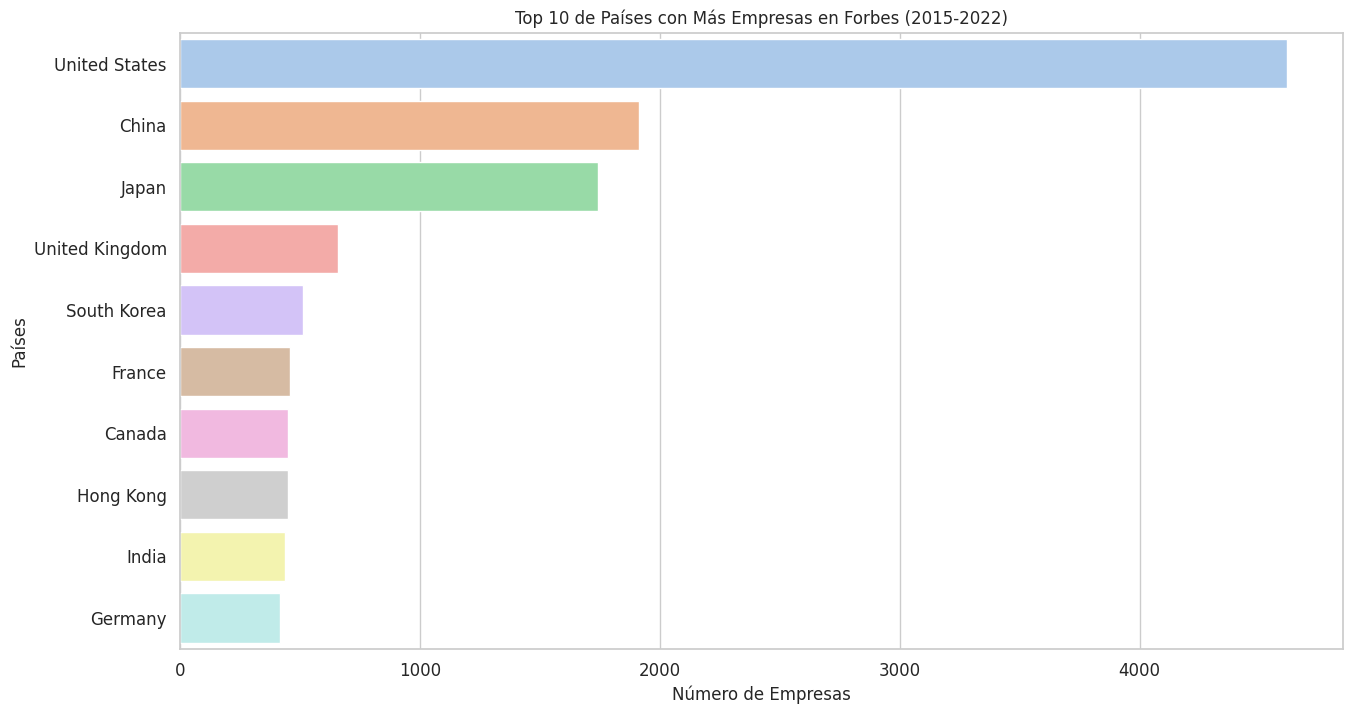

In [ ]:

# Obteniendo el Top 10 de países con más empresas
top_paises = df_concatenado['Pais'].value_counts().nlargest(10)

# Configuración del gráfico
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")
colors = sns.color_palette("pastel")

# Creando el gráfico de barras horizontales
grafico = sns.barplot(x=top_paises.values, y=top_paises.index, palette=colors)

# Configuración adicional del gráfico
plt.title('Top 10 de Países con Más Empresas en Forbes (2015-2022)')
plt.xlabel('Número de Empresas')
plt.ylabel('Países')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


### ¿Cuál es el Top 5 de países con más empresas en el área de tecnología y de telecomunicaciones?

In [ ]:
df_concatenado["Industria"].unique().tolist()

['banking',
 'diversified financials',
 'oil & gas operations',
 'conglomerates',
 'consumer durables',
 'technology hardware & equipment',
 'retailing',
 'semiconductors',
 'telecommunications services',
 'insurance',
 'it software & services',
 'food, drink & tobacco',
 'health care equipment & services',
 'media',
 'drugs & biotechnology',
 'diversified metals & mining',
 'utilities',
 'chemicals',
 'aerospace & defense',
 'construction',
 'trading companies',
 'capital goods',
 'transportation',
 'air courier',
 'real estate',
 'hotels, restaurants & leisure',
 'airline',
 'business services & supplies',
 'food markets',
 'casinos & gaming',
 'materials']

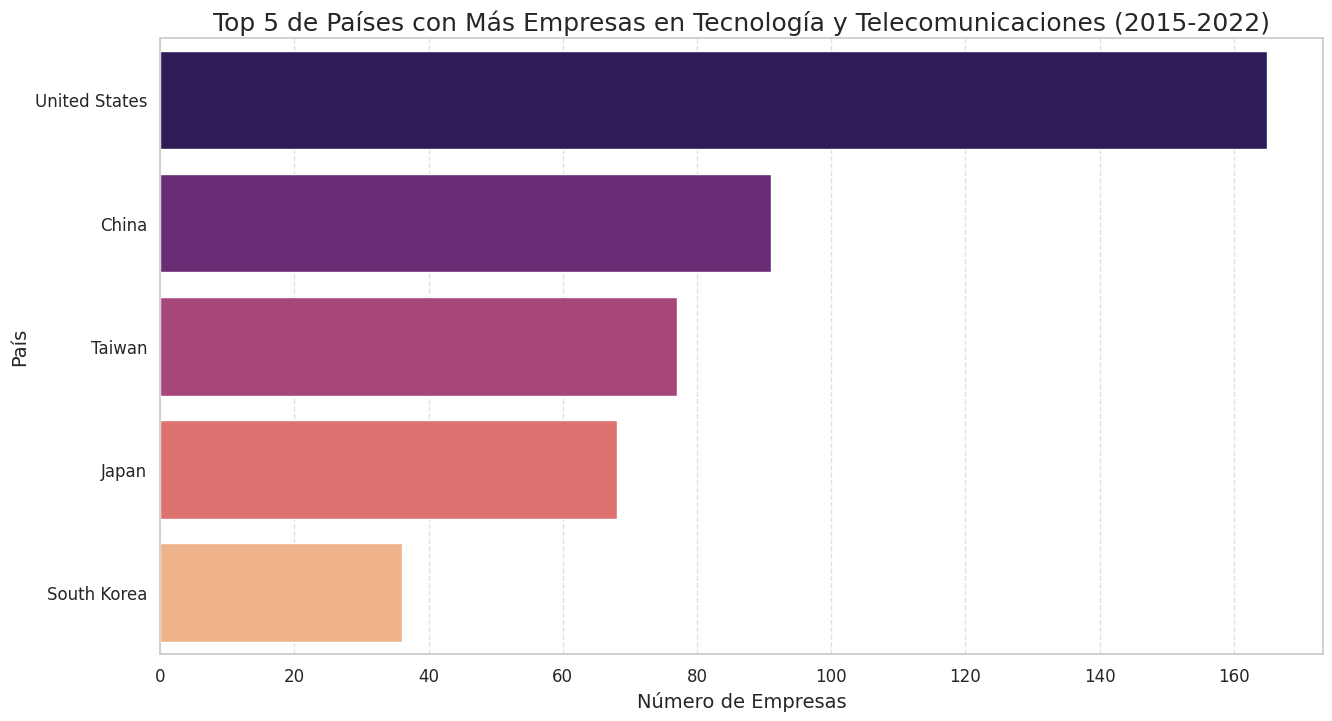

In [ ]:

# Filtrando el DataFrame por las industrias de interés
industrias_interes = ['telecommunications services', 'technology hardware & equipment']
df_filtrado = df_concatenado[df_concatenado['Industria'].isin(industrias_interes)]

# Contando el número de empresas por país
conteo_empresas_por_pais = df_filtrado['Pais'].value_counts().head(5)

# Creando el gráfico de barras horizontales
plt.figure(figsize=(15, 8))
sns.barplot(x=conteo_empresas_por_pais.values, y=conteo_empresas_por_pais.index, palette="magma")

# Personalizando el gráfico
plt.title('Top 5 de Países con Más Empresas en Tecnología y Telecomunicaciones (2015-2022)', fontsize=18)
plt.xlabel('Número de Empresas', fontsize=14)
plt.ylabel('País', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


### ¿Cuál fue el margen de pérdida de las 10 empresas que presentaron mayores perjuicios considerando el total de pérdidas registradas en la Industria de los Hoteles, Restaurantes y entretenimiento?

In [ ]:
df_concatenado.columns

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor de Mercado', 'Margen de Rentabilidad',
       'Rentabilidad de los Activos (ROA)', 'Año', 'Codigo',
       'Nombre_continente'],
      dtype='object')

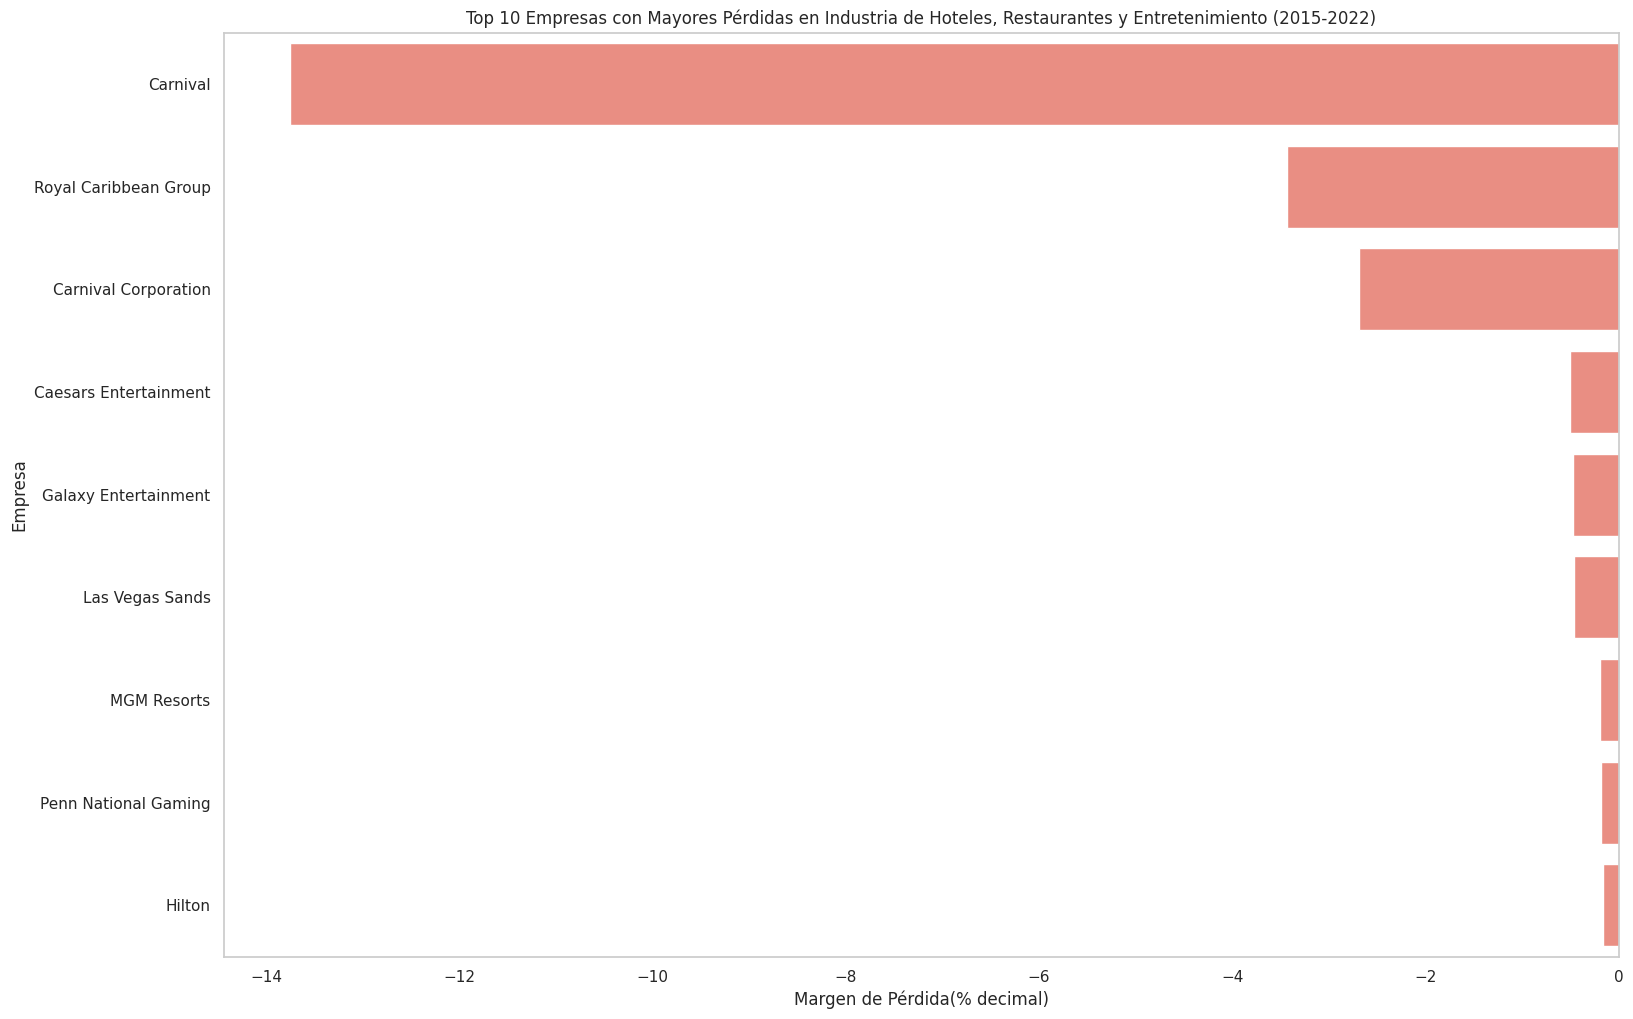

In [ ]:

# Filtrando el dataframe para obtener solo las empresas de la industria 'hotels, restaurants & leisure'
df_industria = df_concatenado[df_concatenado['Industria'] == 'hotels, restaurants & leisure'].copy()

# Filtrando empresas con ganancias negativas
df_industria = df_industria[df_industria['Ganancias'] < 0]

# Calculando la nueva variable 'Margen de Pérdida'
df_industria['Margen de Pérdida'] = df_industria['Ganancias'] / df_industria['Ingresos']

# Ordenando el dataframe por el margen de pérdida de forma descendente
df_industria = df_industria.sort_values(by='Margen de Pérdida', ascending=True)

# Tomando las 12 empresas con mayores pérdidas y manteniendo solo la empresa con el mayor margen de pérdida en caso de duplicados
top_empresas = df_industria.nsmallest(12, "Margen de Pérdida").sort_values(by='Margen de Pérdida', ascending=True).drop_duplicates(subset='Empresa', keep='first')

# Estableciendo el tamaño del lienzo
plt.figure(figsize=(18, 12))

# Creando el gráfico de barras horizontales
sns.barplot(x='Margen de Pérdida', y='Empresa', data=top_empresas, color='salmon')

# Configuraciones adicionales del gráfico
plt.title('Top 10 Empresas con Mayores Pérdidas en Industria de Hoteles, Restaurantes y Entretenimiento (2015-2022)')
plt.xlabel('Margen de Pérdida(% decimal)')
plt.ylabel('Empresa')

# Mostrando el gráfico sin líneas de la cuadrícula
plt.grid(False)

plt.show()


In [ ]:
df_industria.nsmallest(12, "Margen de Pérdida")


Rank_nr                Empresa                      Industria  \
13351    1114               Carnival  hotels, restaurants & leisure   
15652    1376  Royal Caribbean Group  hotels, restaurants & leisure   
15490    1220   Carnival Corporation  hotels, restaurants & leisure   
13638    1398  Royal Caribbean Group  hotels, restaurants & leisure   
13631    1391  Caesars Entertainment  hotels, restaurants & leisure   
14014    1769   Galaxy Entertainment  hotels, restaurants & leisure   
13574    1335        Las Vegas Sands  hotels, restaurants & leisure   
15808    1529        Las Vegas Sands  hotels, restaurants & leisure   
13486    1247            MGM Resorts  hotels, restaurants & leisure   
14237    1986   Penn National Gaming  hotels, restaurants & leisure   
13782    1541                 Hilton  hotels, restaurants & leisure   
11658    1451  Caesars Entertainment  hotels, restaurants & leisure   

                Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
13351  United States     831.0   -11427.0  57226.0           30595.0   
15652  United States    1532.0    -5260.5  32258.0           20821.0   
15490  United States    3506.0    -9419.0  53281.0           21455.0   
13638  United States    2209.0    -5797.5  32465.0           21737.0   
13631  United States    3474.0    -1756.6  36385.0           19503.0   
14014      Hong Kong    1082.0     -512.3  11959.0           38644.0   
13574  United States    3612.0    -1685.0  20807.0           46596.0   
15808  United States    4234.0     -961.0  20059.0           27809.0   
13486  United States    5162.0     -997.2  39129.0           19929.0   
14237  United States    3579.0     -669.5  17126.0           15648.0   
13782  United States    4336.0     -715.0  16755.0           35665.0   
11658  United States    8742.0    -1195.0  25345.0            6607.0   

       Margen de Rentabilidad  Rentabilidad de los Activos (ROA)   Año Codigo  \
13351              -13.750903                          -0.199682  2021    USA   
15652               -3.433747                          -0.163076  2022    USA   
15490               -2.686537                          -0.176780  2022    USA   
13638               -2.624491                          -0.178577  2021    USA   
13631               -0.505642                          -0.048278  2021    USA   
14014               -0.473475                          -0.042838  2021    HKG   
13574               -0.466501                          -0.080982  2021    USA   
15808               -0.226972                          -0.047909  2022    USA   
13486               -0.193181                          -0.025485  2021    USA   
14237               -0.187063                          -0.039093  2021    USA   
13782               -0.164899                          -0.042674  2021    USA   
11658               -0.136696                          -0.047149  2020    USA   

      Nombre_continente  Margen de Pérdida  
13351     North America         -13.750903  
15652     North America          -3.433747  
15490     North America          -2.686537  
13638     North America          -2.624491  
13631     North America          -0.505642  
14014              Asia          -0.473475  
13574     North America          -0.466501  
15808     North America          -0.226972  
13486     North America          -0.193181  
14237     North America          -0.187063  
13782     North America          -0.164899  
11658     North America          -0.136696

### Considerando a la Industria Petrolera en las Américas, ¿Cuál o cuáles empresas superaron en más del 20% la rentabilidad de sus activos?

In [ ]:
df_concatenado["Industria"].unique().tolist()

['banking',
 'diversified financials',
 'oil & gas operations',
 'conglomerates',
 'consumer durables',
 'technology hardware & equipment',
 'retailing',
 'semiconductors',
 'telecommunications services',
 'insurance',
 'it software & services',
 'food, drink & tobacco',
 'health care equipment & services',
 'media',
 'drugs & biotechnology',
 'diversified metals & mining',
 'utilities',
 'chemicals',
 'aerospace & defense',
 'construction',
 'trading companies',
 'capital goods',
 'transportation',
 'air courier',
 'real estate',
 'hotels, restaurants & leisure',
 'airline',
 'business services & supplies',
 'food markets',
 'casinos & gaming',
 'materials']

In [ ]:
df_concatenado["Nombre_continente"].unique().tolist()

['Asia', 'North America', 'Europe', 'South America', 'Oceania', 'Africa']

In [ ]:
df_concatenado["Rentabilidad de los Activos (ROA)"]

0        0.013473
1        0.013724
2        0.011311
3        0.011197
4        0.037170
           ...   
16281    8.483735
16282    0.246089
16283    0.004387
16284    0.121898
16285    0.027842
Name: Rentabilidad de los Activos (ROA), Length: 16257, dtype: float64

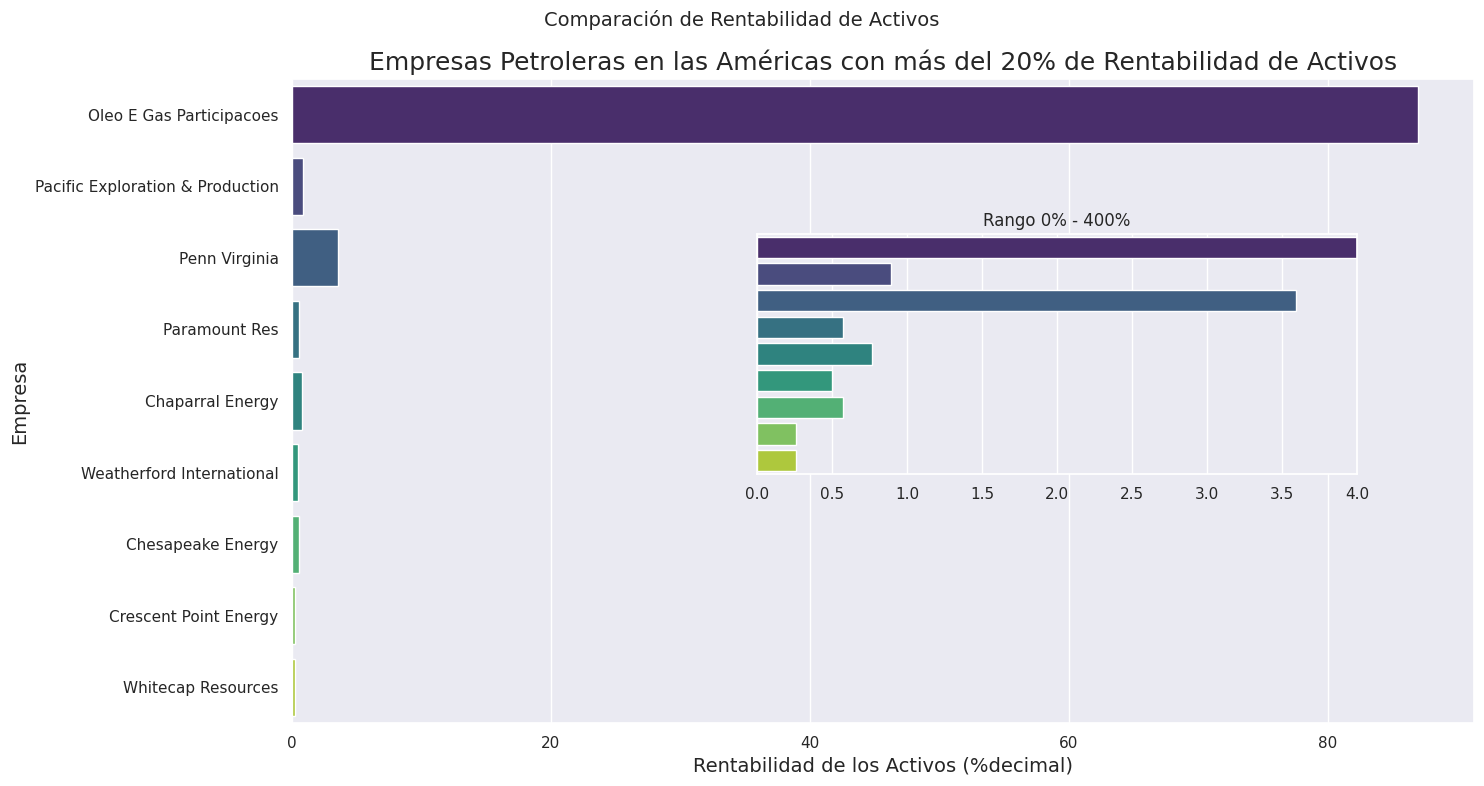

In [ ]:

# Filtrando el dataframe para obtener solo las empresas de la industria petrolera en las Américas
df_petroleras = df_concatenado[(df_concatenado['Industria'] == 'oil & gas operations') &
                               (df_concatenado['Nombre_continente'].isin(['North America', 'South America']))]

# Filtrando para las empresas que superaron en más del 20% la rentabilidad de sus activos
df_superaron_20 = df_petroleras[df_petroleras['Rentabilidad de los Activos (ROA)'] > 0.2]

# Creando el primer gráfico de barras horizontales
plt.figure(figsize=(15, 8))
sns.set_theme()

# Creando el gráfico de barras horizontales
sns.barplot(x='Rentabilidad de los Activos (ROA)', y='Empresa', data=df_superaron_20, palette='viridis')

# Añadiendo título y subtítulo al primer gráfico
plt.title('Empresas Petroleras en las Américas con más del 20% de Rentabilidad de Activos', fontsize=18)
plt.suptitle('Comparación de Rentabilidad de Activos', fontsize=14)

# Etiquetas de los ejes del primer gráfico
plt.xlabel('Rentabilidad de los Activos (%decimal)', fontsize=14)
plt.ylabel('Empresa', fontsize=14)

# Ajustando diseño del primer gráfico
plt.tight_layout()

# Creando el segundo lienzo con zoom en el eje x
axins = plt.axes([0.51, 0.4, 0.4, 0.3])  # [left, bottom, width, height]

# Creando el gráfico de barras horizontales con zoom en el segundo lienzo
sns.barplot(x='Rentabilidad de los Activos (ROA)', y='Empresa', data=df_superaron_20, palette='viridis', ax=axins)

# Ajustando límites del segundo lienzo
axins.set_xlim(0, 4)

# Añadiendo título al segundo lienzo
axins.set_title('Rango 0% - 400%')

# Quitando titulos en labels

axins.set_ylabel("")
axins.set_xlabel("")

# Quitando etiquetas y ticks del segundo lienzo
axins.set_yticks([])

plt.show()


In [ ]:
df_superaron_20.head(20)

Rank_nr                           Empresa             Industria  \
1535     1508          Oleo E Gas Participacoes  oil & gas operations   
5674     1567  Pacific Exploration & Production  oil & gas operations   
5882     1771                     Penn Virginia  oil & gas operations   
5971     1860                     Paramount Res  oil & gas operations   
8110     1963                  Chaparral Energy  oil & gas operations   
11689    1481         Weatherford International  oil & gas operations   
15376    1108                 Chesapeake Energy  oil & gas operations   
16106    1822             Crescent Point Energy  oil & gas operations   
16273    1986                Whitecap Resources  oil & gas operations   

                Pais  Ingresos  Ganancias  Activos  Valor de Mercado  \
1535          Brazil     218.0     4173.7     48.0              73.0   
5674          Canada    1421.0     2455.8   2742.0            1621.0   
5882   United States     132.0     1049.3    292.0             732.0   
5971          Canada     186.0      879.5   1535.0            1407.0   
8110   United States     294.0      923.1   1201.0             988.0   
11689  United States    5215.0     3635.0   7293.0             315.0   
15376  United States    7317.0     6328.0  11009.0           11076.0   
16106         Canada    2257.0     1885.6   7261.0            4031.0   
16273         Canada    1817.0     1417.1   5445.0            5166.0   

       Margen de Rentabilidad  Rentabilidad de los Activos (ROA)   Año Codigo  \
1535                19.145413                          86.952083  2015    BRA   
5674                 1.728220                           0.895624  2017    CAN   
5882                 7.949242                           3.593493  2017    USA   
5971                 4.728495                           0.572964  2017    CAN   
8110                 3.139796                           0.768609  2018    USA   
11689                0.697028                           0.498423  2020    USA   
15376                0.864835                           0.574802  2022    USA   
16106                0.835445                           0.259689  2022    CAN   
16273                0.779912                           0.260257  2022    CAN   

      Nombre_continente  
1535      South America  
5674      North America  
5882      North America  
5971      North America  
8110      North America  
11689     North America  
15376     North America  
16106     North America  
16273     North America

### ¿Cuáles fueron las empresas europeas con el mayor porcentaje de rentabilidad por industria?

In [ ]:
df_concatenado["Nombre_continente"].unique().tolist()

['Asia', 'North America', 'Europe', 'South America', 'Oceania', 'Africa']

In [ ]:
df_concatenado.head()

Rank_nr                     Empresa               Industria           Pais  \
0       1                        ICBC                 banking          China   
1       2     China Construction Bank                 banking          China   
2       3  Agricultural Bank of China                 banking          China   
3       4               Bank of China                 banking          China   
4       5          Berkshire Hathaway  diversified financials  United States   

   Ingresos  Ganancias    Activos  Valor de Mercado  Margen de Rentabilidad  \
0  166796.0    44757.2  3322043.0          278327.0                0.268335   
1  130473.0    37038.9  2698925.0          212945.0                0.283882   
2  129221.0    29124.5  2574815.0          189879.0                0.225385   
3  120297.0    27526.8  2458336.0          199130.0                0.228824   
4  194673.0    19872.0   534618.0          354813.0                0.102079   

   Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
0                           0.013473  2015    CHN              Asia  
1                           0.013724  2015    CHN              Asia  
2                           0.011311  2015    CHN              Asia  
3                           0.011197  2015    CHN              Asia  
4                           0.037170  2015    USA     North America

5 mayores empresas por industria:

In [ ]:
# Filtrando el dataframe para obtener solo las empresas europeas
df_europe = df_concatenado[df_concatenado['Nombre_continente'] == 'Europe']

# Obteniendo las N empresas más rentables por industria (en este caso, N = 5)
n_top = 5
df_top_by_industry = df_europe.groupby('Industria').apply(lambda x: x.nlargest(n_top, 'Margen de Rentabilidad')).reset_index(drop=True)


In [ ]:
df_top_by_industry.head(5)

Rank_nr               Empresa            Industria            Pais  \
0     341  Rolls-Royce Holdings  aerospace & defense  United Kingdom   
1     284                Safran  aerospace & defense          France   
2     999     Dassault Aviation  aerospace & defense          France   
3     319                Safran  aerospace & defense          France   
4    1082     Dassault Aviation  aerospace & defense          France   

   Ingresos  Ganancias  Activos  Valor de Mercado  Margen de Rentabilidad  \
0   21001.0     5417.9  40585.0           21072.0                0.257983   
1   19107.0     4473.4  38722.0           48602.0                0.234124   
2    5451.0      799.7  18318.0           16799.0                0.146707   
3   18232.0     2110.6  32758.0           32196.0                0.115763   
4    6039.0      676.0  19494.0           12121.0                0.111939   

   Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
0                           0.133495  2018    GBR            Europe  
1                           0.115526  2018    FRA            Europe  
2                           0.043657  2018    FRA            Europe  
3                           0.064430  2017    FRA            Europe  
4                           0.034677  2019    FRA            Europe

Empresa con mayor margen de rentabilidad por industria.

In [ ]:
df_top_by_industry = df_europe.loc[df_europe.groupby('Industria')['Margen de Rentabilidad'].idxmax()]


In [ ]:
df_top_by_industry

Rank_nr                                Empresa  \
6459      341                   Rolls-Royce Holdings   
4276      196                          Deutsche Post   
2785      732                       Ryanair Holdings   
13826    1585                 Sparebanken Nord-Norge   
7869     1726                       Rentokil Initial   
8021     1874                                    NKT   
15904    1623                                    K+S   
3970     1896                      Latour Investment   
9238      570                             Aroundtown   
4879      788              Porsche Automobil Holding   
15602    1329                                 Sofina   
7692     1552                                 Polyus   
4229      149                               Allergan   
713       701                                 Magnit   
6204       88               British American Tobacco   
1697     1663                         Rhoen-Klinikum   
3351     1287                InterContinental Hotels   
6997      868                        Deutsche Wohnen   
1964     1927  Mail.ru Group Ltd. Sponsored GDR RegS   
12206    1990                              Holmen AB   
1662     1628                     Seat-Pagine Gialle   
2286      242                         Surgutneftegas   
1935     1899                 Great Portland Estates   
378       374                              Richemont   
3364     1300                           ARM Holdings   
11427    1222                                 Garmin   
14847     587                                Vivendi   
14947     686                               Ferguson   
12050    1837                                  Vopak   
596       585                                 Fortum   

                              Industria            Pais  Ingresos  Ganancias  \
6459                aerospace & defense  United Kingdom   21001.0     5417.9   
4276                        air courier         Germany   63423.0     2919.3   
2785                            airline         Ireland    7046.0     1698.0   
13826                           banking          Norway     481.0     1956.4   
7869       business services & supplies  United Kingdom    3107.0      879.3   
8021                      capital goods         Denmark    1669.0     1048.2   
15904                         chemicals         Germany    3798.0     3526.1   
3970                      conglomerates          Sweden     935.0      488.0   
9238                       construction      Luxembourg       0.0     1912.0   
4879                  consumer durables         Germany       1.0     1519.9   
15602            diversified financials         Belgium     118.0     3065.4   
7692        diversified metals & mining          Russia    2720.0     1237.0   
4229              drugs & biotechnology         Ireland   14967.0    14973.4   
713                        food markets          Russia   19836.0     1241.7   
6204              food, drink & tobacco  United Kingdom   26132.0    48335.8   
1697   health care equipment & services         Germany    2003.0     1631.6   
3351      hotels, restaurants & leisure  United Kingdom    1803.0     1220.5   
6997                          insurance         Germany    1331.0     1937.7   
1964             it software & services          Russia     914.0      834.5   
12206                         materials          Sweden    1794.0      909.7   
1662                              media           Italy     541.0     1829.4   
2286               oil & gas operations          Russia   19020.0    20164.6   
1935                        real estate  United Kingdom     114.0      864.2   
378                           retailing     Switzerland   14588.0     2430.6   
3364                     semiconductors  United Kingdom    1532.0      521.4   
11427   technology hardware & equipment     Switzerland    3848.0      973.5   
14847       telecommunications services          France   11314.0    29185.5   
14947                 trading

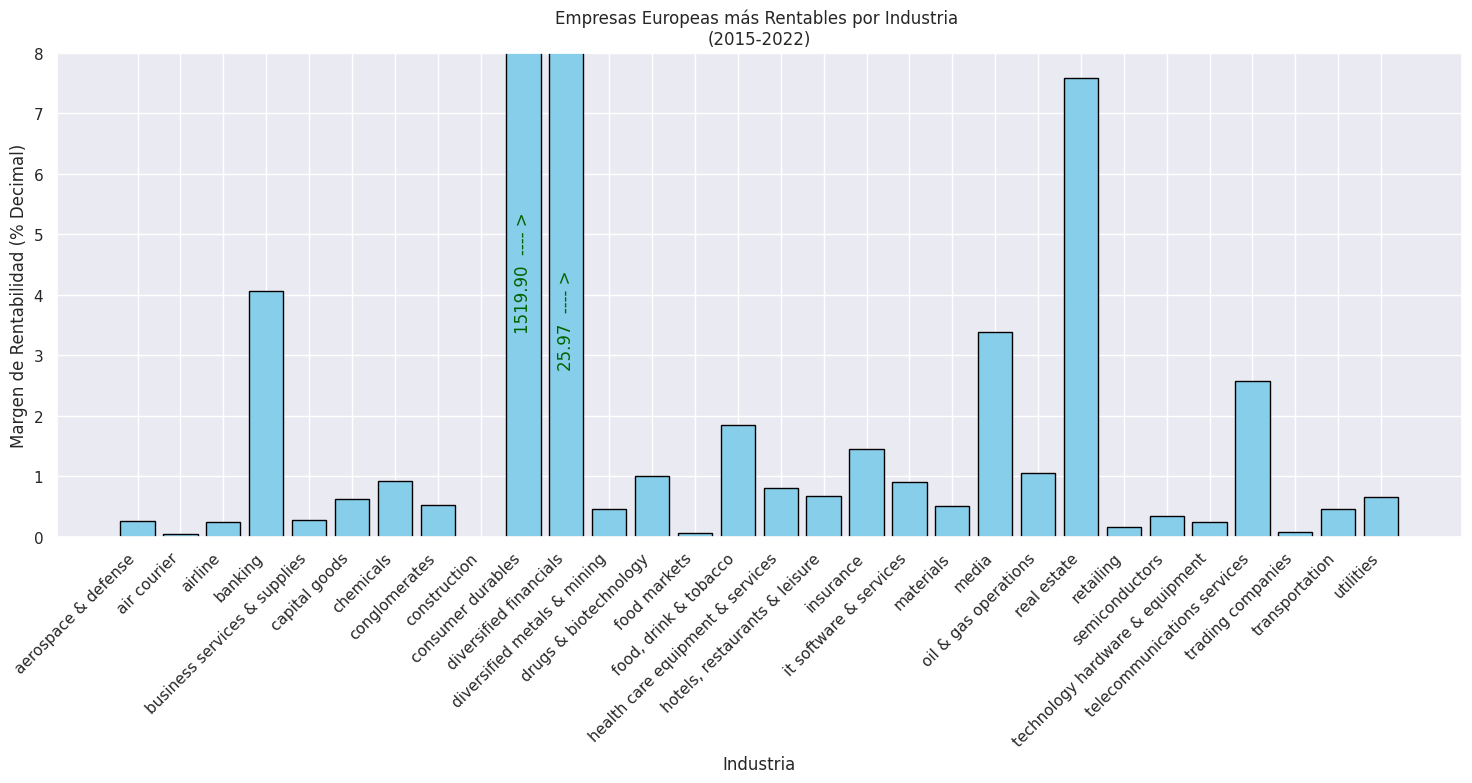

In [ ]:

# Filtrando el dataframe para obtener solo las empresas europeas
df_europe = df_concatenado[df_concatenado['Nombre_continente'] == 'Europe']

# Obteniendo la empresa más rentable por industria
df_top_by_industry = df_europe.loc[df_europe.groupby('Industria')['Margen de Rentabilidad'].idxmax()]

# Configurando el lienzo
plt.figure(figsize=(15, 8))
plt.title('Empresas Europeas más Rentables por Industria \n(2015-2022)')
plt.xlabel('Industria')
plt.ylabel('Margen de Rentabilidad (% Decimal)')
plt.xticks(rotation=45, ha='right')

# Creando el gráfico de barras
bars = plt.bar(df_top_by_industry['Industria'], df_top_by_industry['Margen de Rentabilidad'], color='skyblue', edgecolor='black')

# Agregando texto en dos barras específicas con rotación vertical y color personalizado
plt.text(9, df_top_by_industry.iloc[20]['Margen de Rentabilidad'] + 1, f"1519.90  ---- >", ha='center', va='center', rotation='vertical', color='darkgreen')
plt.text(10, df_top_by_industry.iloc[20]['Margen de Rentabilidad'] + 0.2, f"25.97  ---- >", ha='center', va='center', rotation='vertical', color='darkgreen')

plt.ylim(0, 8)

plt.tight_layout()
plt.show()



### ¿Cuáles fueron las 10 empresas norteamericanas con  mayores pérdidas registradas por industria a nivel global?

In [ ]:
# Revision de datos
df_norteamerica = df_concatenado[df_concatenado['Nombre_continente'] == 'North America']

df_norteamerica = df_norteamerica[df_norteamerica['Ganancias'] < 0]

df_top10_por_industria = df_norteamerica.groupby('Industria').apply(lambda x: x.nlargest(10, 'Ganancias')).reset_index(drop=True)

df_top10_por_industria.max()

Rank_nr                                       2000
Empresa                                    Zscaler
Industria                                utilities
Pais                                 United States
Ingresos                                  213518.0
Ganancias                                     -4.9
Activos                                  1922104.0
Valor de Mercado                          213797.0
Margen de Rentabilidad                    7.322609
Rentabilidad de los Activos (ROA)        -0.000012
Año                                           2022
Codigo                                         USA
Nombre_continente                    North America
dtype: object

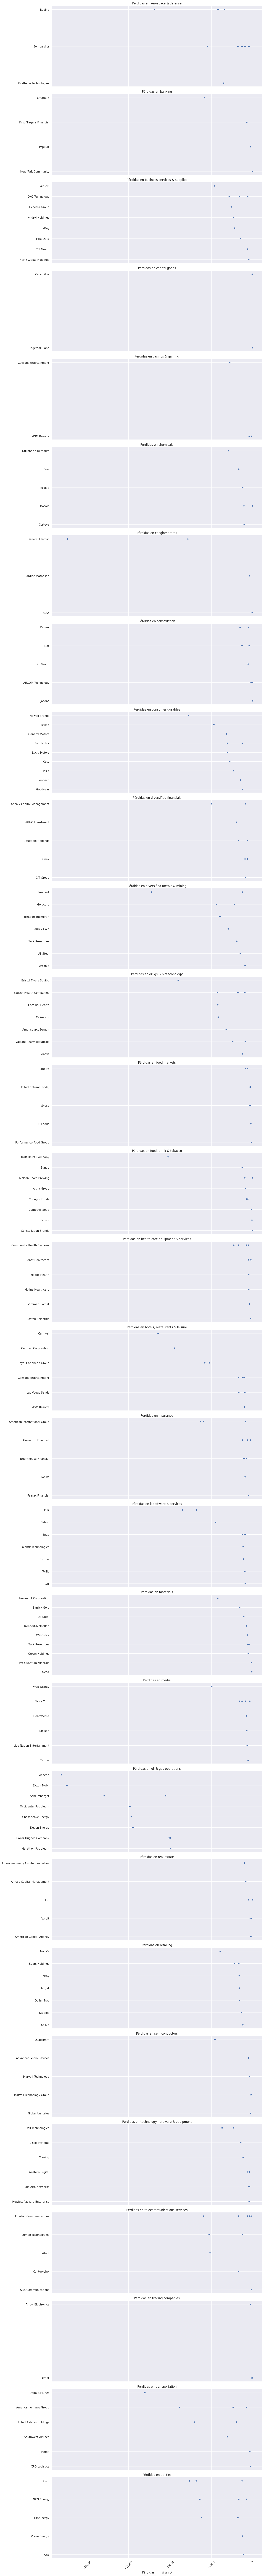

In [ ]:

# Filtrando datos para incluir solo empresas de Norteamérica
df_norteamerica = df_concatenado[df_concatenado['Nombre_continente'] == 'North America']

# Filtrando empresas con pérdidas (valores negativos en 'Ganancias')
df_norteamerica = df_norteamerica[df_norteamerica['Ganancias'] < 0]

# Obteniendo las 10 empresas con mayores pérdidas por cada industria
df_top10_por_industria = df_norteamerica.groupby('Industria').apply(lambda x: x.nsmallest(10, 'Ganancias')).reset_index(drop=True)

# Obteniendo la lista única de industrias
industrias = df_top10_por_industria['Industria'].unique()

# Configurando el tamaño del lienzo
fig, axs = plt.subplots(len(industrias), 1, figsize=(15, 5 * len(industrias)), sharex=True)

# Iterando sobre cada industria y crear un gráfico de dispersión para cada una
for i, industria in enumerate(industrias):
    df_industria = df_top10_por_industria[df_top10_por_industria['Industria'] == industria]

    # Creando un gráfico de dispersión para la industria actual
    sns.scatterplot(ax=axs[i], x='Ganancias', y='Empresa', data=df_industria)

    # Añadiendo títulos y etiquetas para cada subgráfico
    axs[i].set_title(f'Pérdidas en {industria}')
    axs[i].set_xlabel('Pérdidas (mil $ unit)')
    axs[i].set_ylabel('')

    # Añadiendo ticks en el eje x
    axs[i].tick_params(axis='x', rotation=45)  # Ajusta según sea necesario

# Ajustando el espaciado entre subgráficos
plt.tight_layout()

plt.show()


### ¿Cuál fue la distribución de Ingresos y Activos con respecto a las ganancias de los bancos cuyos activos no superan los 1,500 millones de dólares?

In [ ]:
df_concatenado.Industria.unique().tolist()

['banking',
 'diversified financials',
 'oil & gas operations',
 'conglomerates',
 'consumer durables',
 'technology hardware & equipment',
 'retailing',
 'semiconductors',
 'telecommunications services',
 'insurance',
 'it software & services',
 'food, drink & tobacco',
 'health care equipment & services',
 'media',
 'drugs & biotechnology',
 'diversified metals & mining',
 'utilities',
 'chemicals',
 'aerospace & defense',
 'construction',
 'trading companies',
 'capital goods',
 'transportation',
 'air courier',
 'real estate',
 'hotels, restaurants & leisure',
 'airline',
 'business services & supplies',
 'food markets',
 'casinos & gaming',
 'materials']

In [ ]:
df_concatenado.head()

Rank_nr                     Empresa               Industria           Pais  \
0       1                        ICBC                 banking          China   
1       2     China Construction Bank                 banking          China   
2       3  Agricultural Bank of China                 banking          China   
3       4               Bank of China                 banking          China   
4       5          Berkshire Hathaway  diversified financials  United States   

   Ingresos  Ganancias    Activos  Valor de Mercado  Margen de Rentabilidad  \
0  166796.0    44757.2  3322043.0          278327.0                0.268335   
1  130473.0    37038.9  2698925.0          212945.0                0.283882   
2  129221.0    29124.5  2574815.0          189879.0                0.225385   
3  120297.0    27526.8  2458336.0          199130.0                0.228824   
4  194673.0    19872.0   534618.0          354813.0                0.102079   

   Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
0                           0.013473  2015    CHN              Asia  
1                           0.013724  2015    CHN              Asia  
2                           0.011311  2015    CHN              Asia  
3                           0.011197  2015    CHN              Asia  
4                           0.037170  2015    USA     North America

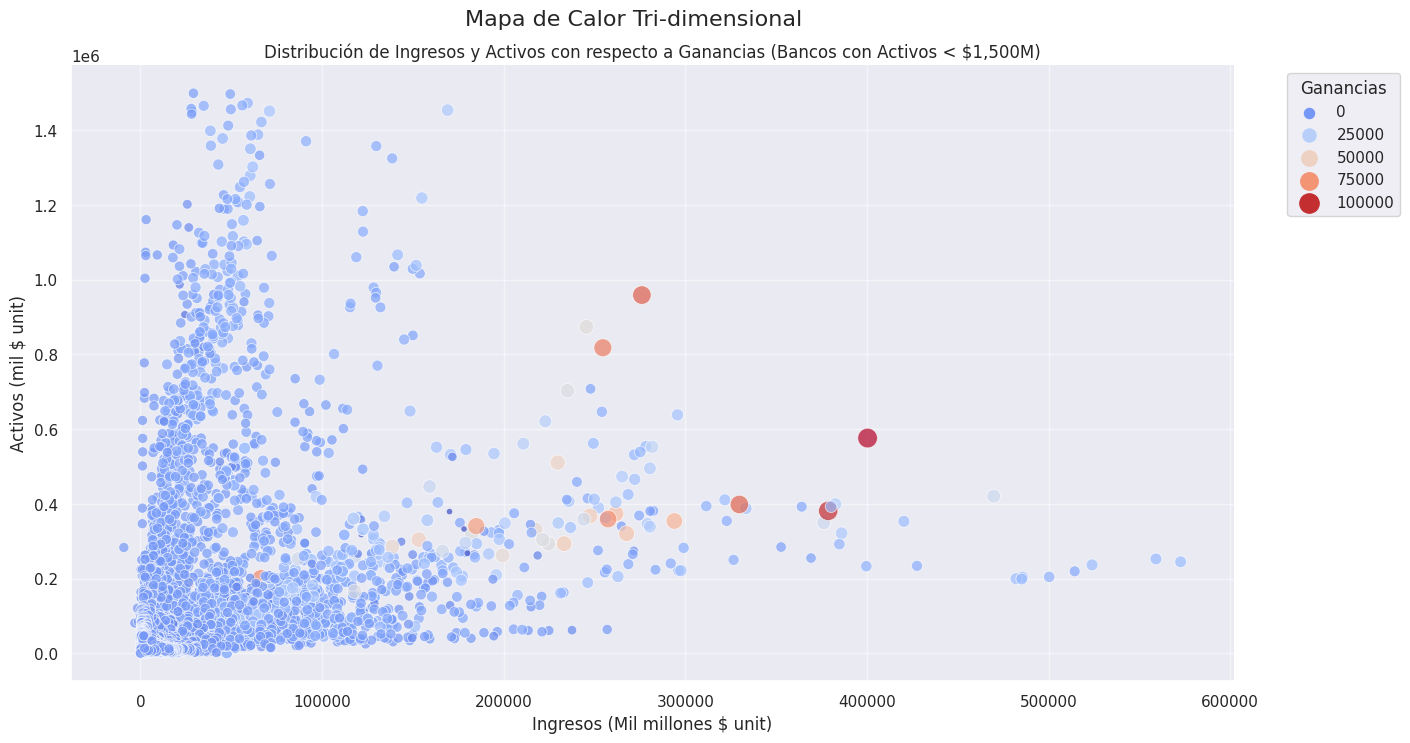

In [ ]:

# Filtrando datos para bancos con activos menores a 1500 millones de dólares
df_filt = df_concatenado[df_concatenado['Activos'] < 1500000.0]

# Estableciendo el tamaño del lienzo
plt.figure(figsize=(15, 8))

# Creando el mapa de calor tri-dimensional
heatmap = sns.scatterplot(x='Ingresos', y='Activos', size='Ganancias', sizes=(20, 200),
                         hue='Ganancias', data=df_filt, palette='coolwarm', alpha=0.7)

# Añadiendo título y subtítulo
plt.title('Distribución de Ingresos y Activos con respecto a Ganancias (Bancos con Activos < $1,500M)')
plt.suptitle('Mapa de Calor Tri-dimensional', y=0.95, fontsize=16)

# Etiquetas de los ejes
plt.xlabel('Ingresos (Mil millones $ unit)')
plt.ylabel('Activos (mil $ unit)')

# Leyenda
plt.legend(title='Ganancias', loc='upper right', bbox_to_anchor=(1.15, 1))

# Ajustes de la paleta de colores y estilo
sns.set_style("whitegrid")
plt.grid(True, alpha=0.5)
sns.despine()

plt.show()


### ¿Cuáles fueron las ganancias anuales de las principales empresas en la Industria automotriz?

In [ ]:
df_concatenado.Industria.unique().tolist()

['banking',
 'diversified financials',
 'oil & gas operations',
 'conglomerates',
 'consumer durables',
 'technology hardware & equipment',
 'retailing',
 'semiconductors',
 'telecommunications services',
 'insurance',
 'it software & services',
 'food, drink & tobacco',
 'health care equipment & services',
 'media',
 'drugs & biotechnology',
 'diversified metals & mining',
 'utilities',
 'chemicals',
 'aerospace & defense',
 'construction',
 'trading companies',
 'capital goods',
 'transportation',
 'air courier',
 'real estate',
 'hotels, restaurants & leisure',
 'airline',
 'business services & supplies',
 'food markets',
 'casinos & gaming',
 'materials']

In [ ]:
df_concatenado[df_concatenado["Industria"] == 'consumer durables']["Empresa"].unique().tolist()

['Toyota Motor',
 'Volkswagen Group',
 'Daimler',
 'Procter & Gamble',
 'BMW Group',
 'Honda Motor',
 'General Motors',
 'Ford Motor',
 'Nissan Motor',
 'Unilever',
 'Hyundai Motor',
 'Hon Hai Precision',
 'SAIC Motor',
 'Hitachi',
 "L'Oréal Group",
 'Christian Dior',
 'Renault',
 'Continental',
 'Denso',
 'Tata Motors',
 'Bridgestone',
 'Fiat Chrysler Automobiles',
 'NIKE',
 'Hyundai Mobis',
 'Reckitt Benckiser Group',
 'KIA Motors',
 'Johnson Controls',
 'Henkel',
 'Inditex',
 'Toshiba',
 'Gree Electric Appliances',
 'Michelin Group',
 'Magna International',
 'Toyota Industries',
 'Fuji Heavy Industries',
 'Midea Group Co. Ltd.',
 'Fujifilm Holdings',
 'Colgate-Palmolive',
 'Kimberly-Clark',
 'TJX Cos',
 'TE Connectivity',
 'H&M',
 'Sony',
 'Suzuki Motor',
 'Mazda Motor',
 'Dongfeng Motor Group',
 'Kering',
 'Kyocera',
 'Panasonic',
 'Sumitomo Electric',
 'SCA',
 'Steinhoff International',
 'Delphi Automotive',
 'Whirlpool',
 'Aisin Seiki',
 'LG Display',
 'Peugeot',
 'Swatch Group',

In [ ]:
df_concatenado[df_concatenado["Empresa"] == 'Toyota Motor']

Rank_nr       Empresa          Industria   Pais  Ingresos  Ganancias  \
10         11  Toyota Motor  consumer durables  Japan  252185.0    19120.4   
2050       10  Toyota Motor  consumer durables  Japan  235832.0    19267.0   
4086       10  Toyota Motor  consumer durables  Japan  249902.0    17111.5   
6124       12  Toyota Motor  consumer durables  Japan  265165.0    22502.2   
8164       15  Toyota Motor  consumer durables  Japan  272144.0    17241.0   
10194      11  Toyota Motor  consumer durables  Japan  280529.0    22681.9   
12227      12  Toyota Motor  consumer durables  Japan  249370.0    14341.7   
14261      10  Toyota Motor  consumer durables  Japan  281746.0    28154.4   

        Activos  Valor de Mercado  Margen de Rentabilidad  \
10     389693.0          239045.0                0.075819   
2050   406692.0          176960.0                0.081698   
4086   412496.0          171850.0                0.068473   
6124   473044.0          200682.0                0.084861   
8164   465625.0          176602.0                0.063352   
10194  495064.0          173300.0                0.080854   
12227  561870.0          219175.0                0.057512   
14261  552456.0          237726.0                0.099928   

       Rentabilidad de los Activos (ROA)   Año Codigo Nombre_continente  
10                              0.049065  2015    JPN              Asia  
2050                            0.047375  2016    JPN              Asia  
4086                            0.041483  2017    JPN              Asia  
6124                            0.047569  2018    JPN              Asia  
8164                            0.037028  2019    JPN              Asia  
10194                           0.045816  2020    JPN              Asia  
12227                           0.025525  2021    JPN              Asia  
14261                           0.050962  2022    JPN              Asia

####Ganancias anuales de todas las empresas de la industria automotriz que entraron al ranking de forbes:

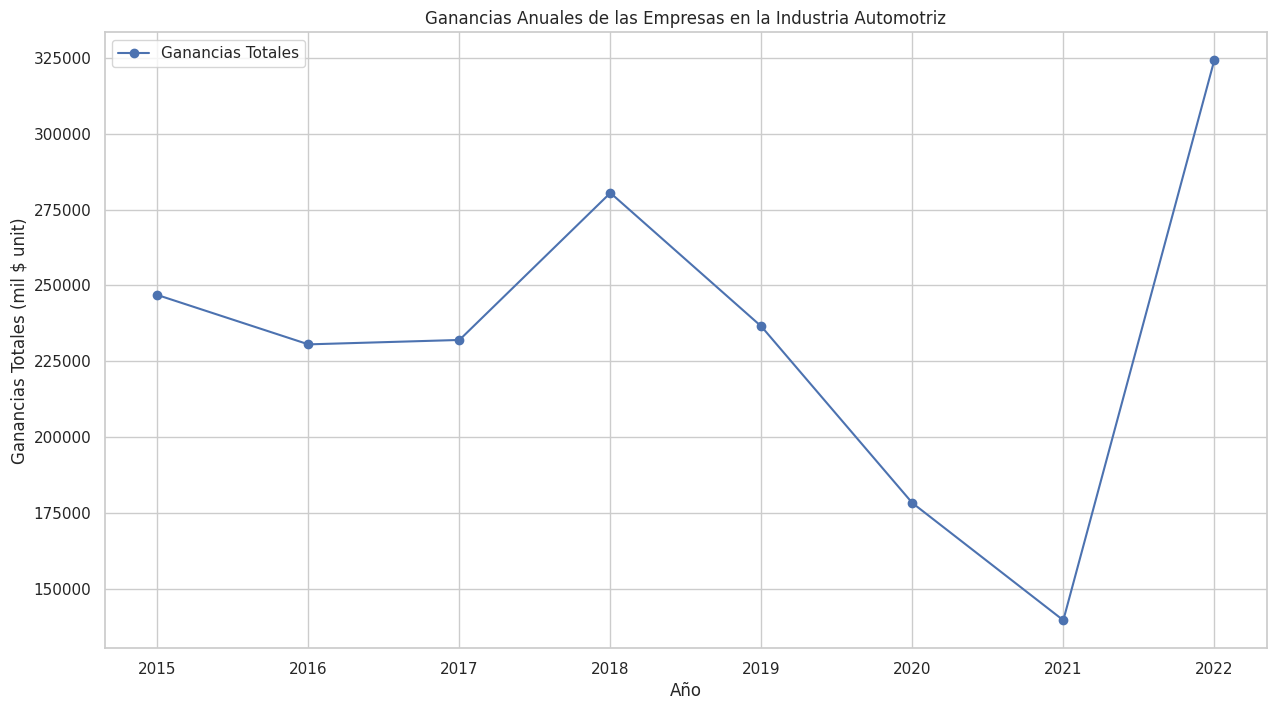

In [ ]:

# Filtrando el dataframe para obtener solo las empresas de la industria automotriz
df_automotriz = df_concatenado[df_concatenado['Industria'] == 'consumer durables']

# Agrupando por año y suma las ganancias de todas las empresas en cada año
ganancias_totales_por_anio = df_automotriz.groupby('Año')['Ganancias'].sum()

# Configuración del gráfico
plt.figure(figsize=(15, 8))
plt.plot(ganancias_totales_por_anio, marker='o', color='b', label='Ganancias Totales')
plt.title('Ganancias Anuales de las Empresas en la Industria Automotriz')
plt.xlabel('Año')
plt.ylabel('Ganancias Totales (mil $ unit)')
plt.legend()
plt.grid(True)
plt.show()


#### Empresas con mayores ganancias en todo el periodo 2015-2022:

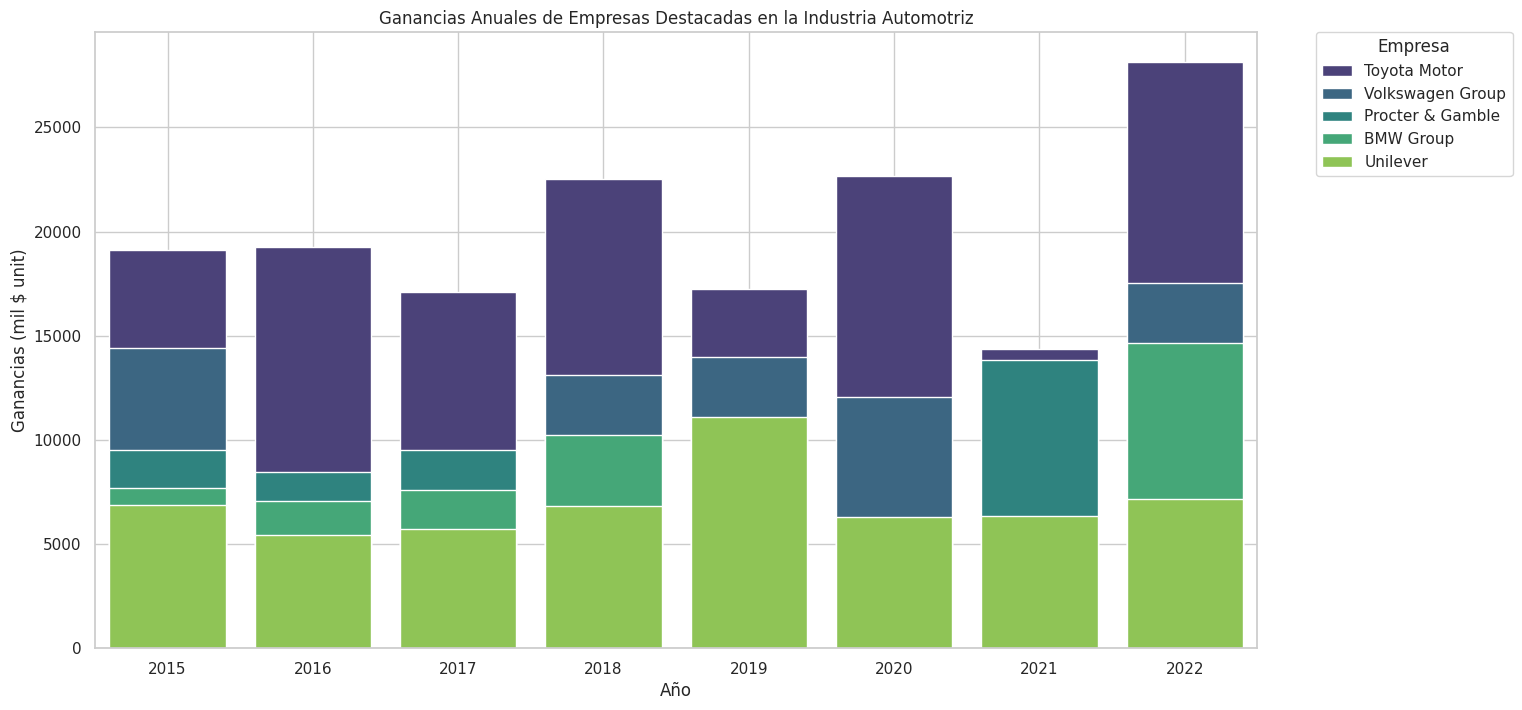

In [ ]:

# Filtrando el dataframe para obtener solo las empresas de la industria automotriz
df_automotriz = df_concatenado[df_concatenado['Industria'] == 'consumer durables']

# Identificando las empresas con mayores ganancias (puedes ajustar el umbral según tus necesidades)
empresas_destacadas = df_automotriz.groupby('Empresa')['Ganancias'].sum().nlargest(5).index

# Filtrando el dataframe solo para las empresas destacadas
df_destacadas = df_automotriz[df_automotriz['Empresa'].isin(empresas_destacadas)]

# Configuración del gráfico de barras apiladas
plt.figure(figsize=(15, 8))
sns.barplot(x='Año', y='Ganancias', hue='Empresa', data=df_destacadas, palette='viridis', errorbar=None, dodge=False)
plt.title('Ganancias Anuales de Empresas Destacadas en la Industria Automotriz')
plt.xlabel('Año')
plt.ylabel('Ganancias (mil $ unit)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Empresa')
plt.grid(True)
plt.show()



#### Dispersion de las Empresas en el ranking de forbes de la industria automotriz por cada año

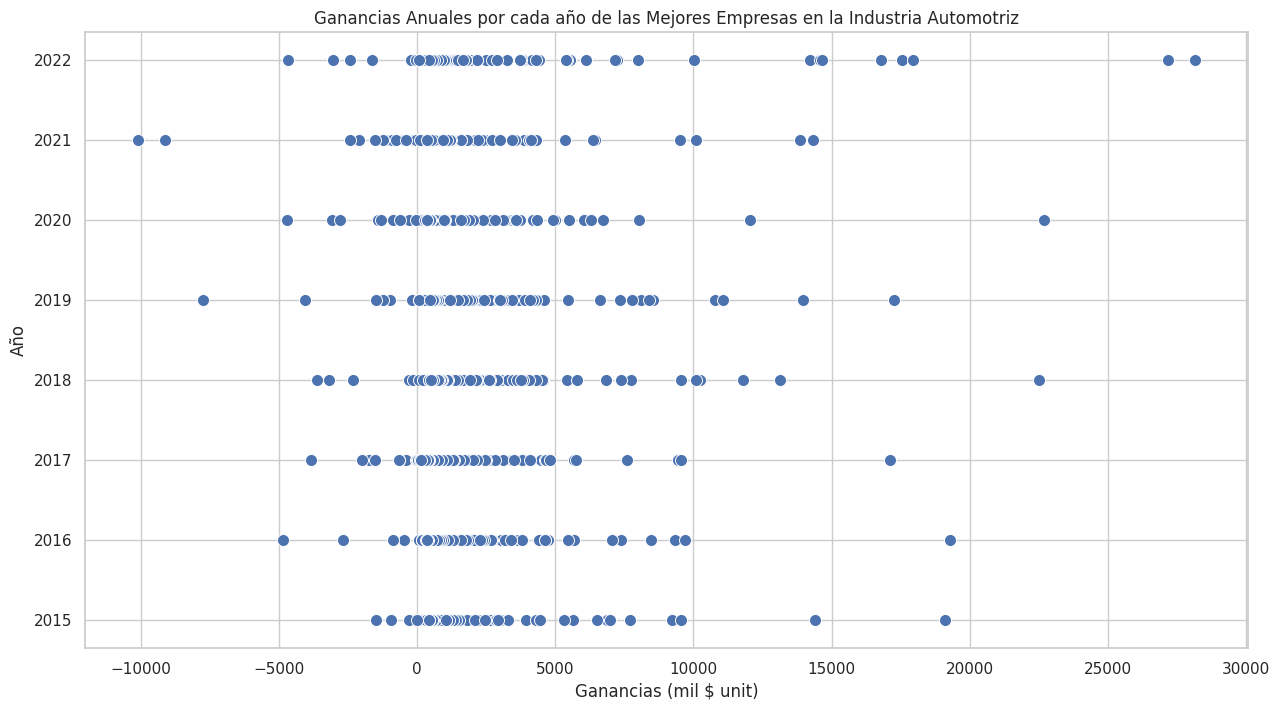

In [ ]:

# Filtrando el dataframe para obtener solo las empresas de la industria automotriz
df_automotriz = df_concatenado[df_concatenado['Industria'] == 'consumer durables']

# Configuración del gráfico de dispersión
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Ganancias', y='Año', data=df_automotriz, s=75)
plt.title('Ganancias Anuales por cada año de las Mejores Empresas en la Industria Automotriz')
plt.xlabel('Ganancias (mil $ unit)')
plt.ylabel('Año')
plt.grid(True)
plt.show()


## Extra:

### Gráfico de carrera de barras (racing bar chart) que indique la variación del valor de mercado por industria durante el periodo 2015 - 2022.

In [ ]:

# Calculando el valor total de mercado por industria y año
valor_mercado_total = df_concatenado.groupby(['Industria', 'Año'])['Valor de Mercado'].sum().reset_index()

# Seleccionando las 10 industrias con los mayores valores de mercado para cada año
top_industrias_por_año = (valor_mercado_total.groupby('Año')
                          .apply(lambda x: x.nlargest(10, 'Valor de Mercado'))
                          .reset_index(drop=True))

# Lista completa de todas las industrias para cada año
all_industries = top_industrias_por_año['Industria'].unique()

# Creando el gráfico de carrera de barras con plotly para las 10 mejores industrias
fig = px.bar(top_industrias_por_año,
             x='Valor de Mercado',
             y='Industria',
             animation_frame='Año',
             animation_group='Industria',  # Agrega este parámetro para asegurar consistencia entre frames
             orientation='h',
             title='Variación del Valor de Mercado por Industria (2015-2022) - Top 10 Industrias',
             labels={'Valor de Mercado': 'Valor de Mercado ($)', 'Industria': 'Industria'},
             width=1200,
             height=600,
             range_x=[0, top_industrias_por_año['Valor de Mercado'].max() * 1.1],
             color='Industria',
             category_orders={'Industria': all_industries},  # Asegura el orden correcto de las categorías
             )

# Ajustando la apariencia del gráfico
fig.update_layout(showlegend=False)  # Puedes ajustar esto según tus preferencias

# Estableciendo el orden de las etiquetas del eje y según el valor de mercado en cada año
fig.update_layout(yaxis={'categoryorder': 'total descending'})

# Ajustando la duración de la transición (en milisegundos)
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=4000, redraw=True), fromcurrent=True, transition=dict(duration=1400))]
                ),
                dict(
                    label='Pause',
                    method='animate',
                    args=[[None], dict(frame=dict(duration=0, redraw=True), mode='immediate')]
                )
            ]
        )
    ]
)

# Guardando el gráfico como un archivo HTML o visualízalo directamente
fig.write_html("valor_mercado_top_10_industrias.html")
# Opcional: Si prefieres visualizar el gráfico directamente en Colab, puedes usar el siguiente comando:
fig.show()




In [ ]:
top_industrias_por_año.Industria.unique()

array(['banking', 'consumer durables', 'oil & gas operations',
       'drugs & biotechnology', 'food, drink & tobacco',
       'it software & services', 'telecommunications services',
       'diversified financials', 'insurance', 'retailing',
       'technology hardware & equipment', 'business services & supplies',
       'semiconductors'], dtype=object)

In [ ]:
top_industrias_por_año[top_industrias_por_año["Año"] == 2020]

Industria   Año  Valor de Mercado
50           it software & services  2020         5857263.0
51                          banking  2020         4763575.0
52             oil & gas operations  2020         4356818.0
53            drugs & biotechnology  2020         4102388.0
54                        retailing  2020         3635037.0
55                consumer durables  2020         3394476.0
56           diversified financials  2020         3025298.0
57            food, drink & tobacco  2020         2724895.0
58  technology hardware & equipment  2020         2713868.0
59     business services & supplies  2020         2241923.0

In [ ]:
top_industrias_por_año[top_industrias_por_año["Año"] == 2016]

Industria   Año  Valor de Mercado
10                      banking  2016         5661775.0
11            consumer durables  2016         3713018.0
12         oil & gas operations  2016         3503955.0
13        drugs & biotechnology  2016         2966399.0
14       it software & services  2016         2717870.0
15        food, drink & tobacco  2016         2714813.0
16  telecommunications services  2016         2150791.0
17       diversified financials  2016         2074890.0
18                    insurance  2016         1796957.0
19                    retailing  2016         1774403.0

In [ ]:
top_industrias_por_año[top_industrias_por_año["Año"] == 2017]

Industria   Año  Valor de Mercado
20                      banking  2017         6622154.0
21            consumer durables  2017         4007848.0
22         oil & gas operations  2017         3777980.0
23       it software & services  2017         3226920.0
24        food, drink & tobacco  2017         2769867.0
25        drugs & biotechnology  2017         2762881.0
26       diversified financials  2017         2295099.0
27  telecommunications services  2017         2049429.0
28                    insurance  2017         1947650.0
29                    retailing  2017         1895131.0

In [ ]:
top_industrias_por_año[top_industrias_por_año["Año"] == 2022]

Industria   Año  Valor de Mercado
70           it software & services  2022         7957091.0
71             oil & gas operations  2022         6674843.0
72                          banking  2022         6560009.0
73                consumer durables  2022         5479156.0
74            drugs & biotechnology  2022         4842857.0
75           diversified financials  2022         4782565.0
76  technology hardware & equipment  2022         4460586.0
77                        retailing  2022         4230353.0
78            food, drink & tobacco  2022         3684751.0
79                   semiconductors  2022         3144994.0

### Gráfico de carrera de barras que muestre la variación del número de empleados por industria durante el periodo 2015 - 2022.

In [ ]:
df_union_secundario_final.columns

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor de Mercado', 'Margen de Rentabilidad',
       'Rentabilidad de los Activos (ROA)', 'Año', 'Codigo',
       'Nombre_continente', 'Empleados'],
      dtype='object')

Grafico de barras por video guardado:

In [288]:
# Filtrando datos relevantes
df_variacion_empleados = df_union_secundario_final.groupby(['Año', 'Industria'])['Empleados'].sum().unstack()

# Creando el gráfico de carrera de barras
bcr.bar_chart_race(
    df=df_variacion_empleados,
    filename='carrera_empleados_industria.mp4',
    title='Variación del Número de Empleados por Industria (2015-2022)',
    n_bars=10,
    filter_column_colors=True,
    bar_size=0.95,
    cmap='dark24',
    period_length=1000,
    figsize=(15, 8),
    title_size=18,
    tick_label_size=12,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer='ffmpeg',
    fig=None
)


/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:286: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.10/dist-packages/bar_chart_race/_make_chart.py:287: UserWarning:

FixedFormatter should only be used together with FixedLocator



Grafico de barras directamente en el notebook:

In [ ]:

# Filtrando datos relevantes
df_variacion_empleados = df_union_secundario_final.groupby(['Año', 'Industria'])['Empleados'].sum().unstack()

# Configurando el gráfico de carrera de barras
bcr.bar_chart_race(
    df=df_variacion_empleados,
    title='Variación del Número de Empleados por Industria (2015-2022)',
    n_bars=15,
    filter_column_colors=True,
    bar_size=0.95,
    cmap='dark24',
    period_length=1000,
    figsize=(15, 8),
    title_size=18,
    tick_label_size=12,
    shared_fontdict={'family': 'sans-serif', 'color': '.1'},
    scale='linear',
    writer=None,  # No se guarda el video, solo se muestra en el notebook
    fig=None
)




Se truncaron las últimas líneas 5000 del resultado de transmisión.


In [ ]:
df_variacion_empleados.head()

Industria  aerospace & defense  air courier   airline    banking  \
Año                                                                
2015                  571400.0     741883.0  276955.0  5256420.0   
2016                  638800.0     773543.0  285449.0  5041587.0   
2017                  552340.0     335767.0  294056.0  4820808.0   
2018                  549400.0     404336.0  302964.0  4717353.0   
2019                  541239.0          NaN       NaN  3939720.0   

Industria  business services & supplies  capital goods  chemicals  \
Año                                                                 
2015                           688515.0       827923.0   298496.0   
2016                           718201.0      1006874.0   170543.0   
2017                           931326.0       856686.0   293713.0   
2018                           506706.0       813360.0   322332.0   
2019                           378677.0       668151.0   241548.0   

Industria  conglomerates  construction  consumer durables  ...     media  \
Año                                                        ...             
2015           2032965.0     1077717.0          5183790.0  ...  371600.0   
2016           1673946.0     1215266.0          5541238.0  ...  198300.0   
2017           1633484.0     1282366.0          5022566.0  ...  297000.0   
2018           1691536.0     1323256.0          5568684.0  ...  329800.0   
2019           2021257.0     1727215.0          4697273.0  ...  483000.0   

Industria  oil & gas operations  real estate  retailing  semiconductors  \
Año                                                                       
2015                  2193159.0          NaN  1639586.0        488591.0   
2016                  1932515.0      42295.0  2410036.0        459300.0   
2017                  2006613.0     297680.0  2597109.0        461500.0   
2018                  2103177.0     408821.0  4895823.0        451371.0   
2019                  2178743.0          NaN  4803267.0        176400.0   

Industria  technology hardware & equipment  telecommunications services  \
Año                                                                       
2015                              763374.0                     892456.0   
2016                              920311.0                     916234.0   
2017                             1038882.0                     897133.0   
2018                             1108801.0                     852151.0   
2019                             1841556.0                     927802.0   

Industria  trading companies  transportation  utilities  
Año                                                      
2015                157980.0        134187.0   565250.0  
2016                203938.0        133584.0   564041.0  
2017                421818.0         85834.0   558254.0  
2018                498931.0         86389.0   516627.0  
2019                592684.0       1119403.0   512201.0  

[5 rows x 30 columns]

### Utilizando la biblioteca   de Plotly, genera un mapa con el total de ventas globales por país en el año 2020

In [ ]:
df_concatenado.columns.unique()

Index(['Rank_nr', 'Empresa', 'Industria', 'Pais', 'Ingresos', 'Ganancias',
       'Activos', 'Valor de Mercado', 'Margen de Rentabilidad',
       'Rentabilidad de los Activos (ROA)', 'Año', 'Codigo',
       'Nombre_continente'],
      dtype='object')

In [ ]:

# Filtrando el DataFrame para obtener solo los datos del año 2020
df_2020 = df_concatenado[df_concatenado['Año'] == 2020].copy()

# Agrupando por país y calculando la suma de ingresos por país
df_agrupado = df_2020.groupby('Codigo')['Ingresos'].sum().reset_index()

# Creando una nueva columna en df_2020 con los ingresos totales por país
df_2020['Total_ingresos_pais'] = df_2020['Codigo'].map(df_agrupado.set_index('Codigo')['Ingresos'])

# Creando el mapa de ventas globales por país en el año 2020
fig = px.choropleth(
    df_2020,
    locations='Codigo',
    color='Total_ingresos_pais',
    hover_name='Pais',
    title='Ventas Globales por País en el Año 2020',
    labels={'Total_ingresos_pais': 'Ventas Globales (en miles de dólares)'},
    color_continuous_scale=px.colors.sequential.Plasma,
    projection='natural earth',
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    height=800,
    width=1500,
    title=dict(
        text='Ventas Globales por País en el Año 2020',
        x=0.5,
    ),
    font=dict(size=16),
)

fig.show()


In [ ]:
df_2020

Rank_nr                         Empresa               Industria  \
10183       1                            ICBC                 banking   
10184       2         China Construction Bank                 banking   
10185       3                  JPMorgan Chase  diversified financials   
10186       4              Berkshire Hathaway  diversified financials   
10187       5      Agricultural Bank of China                 banking   
...       ...                             ...                     ...   
12211    1995              Founder Securities  diversified financials   
12212    1995    Merlin Properties SOCIMI S.A  diversified financials   
12213    1998                           Heico     aerospace & defense   
12214    1999                      W.P. Carey  diversified financials   
12215    1999  Zhejiang Century Huatong Group       consumer durables   

                Pais  Ingresos  Ganancias    Activos  Valor de Mercado  \
10183          China  177230.0    45283.6  4322528.0          242283.0   
10184          China  162147.0    38914.8  3822048.0          203818.0   
10185  United States  142927.0    29954.0  3139431.0          291737.0   
10186  United States  254616.0    81417.0   817729.0          455444.0   
10187          China  148692.0    30911.6  3697451.0          147174.0   
...              ...       ...        ...        ...               ...   
12211          China    1391.0      114.7    18623.0            8300.0   
12212          Spain     594.0      630.9    14936.0            4306.0   
12213  United States    2096.0      370.5     3097.0           11796.0   
12214  United States    1246.0      305.2    14061.0           11341.0   
12215          China    2182.0      364.8     4720.0           12081.0   

       Margen de Rentabilidad  Rentabilidad de los Activos (ROA)   Año Codigo  \
10183                0.255508                           0.010476  2020    CHN   
10184                0.239997                           0.010182  2020    CHN   
10185                0.209576                           0.009541  2020    USA   
10186                0.319764                           0.099565  2020    USA   
10187                0.207890                           0.008360  2020    CHN   
...                       ...                                ...   ...    ...   
12211                0.082459                           0.006159  2020    CHN   
12212                1.062121                           0.042240  2020    ESP   
12213                0.176765                           0.119632  2020    USA   
12214                0.244944                           0.021705  2020    USA   
12215                0.167186                           0.077288  2020    CHN   

      Nombre_continente  Total_ingresos_pais  
10183              Asia            6044515.0  
10184              Asia            6044515.0  
10185     North America           13592016.0  
10186     North America           13592016.0  
10187              Asia            6044515.0  
...                 ...                  ...  
12211              Asia            6044515.0  
12212            Europe             465953.0  
12213     North America           13592016.0  
12214     North America           13592016.0  
12215              Asia            6044515.0  

[2033 rows x 14 columns]